In [41]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
import torch.nn as nn
import os
from IPython.display import Image
from torchvision.utils import save_image
from tqdm import tqdm
import cv2
from IPython.display import FileLink

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [6]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

Label: 5


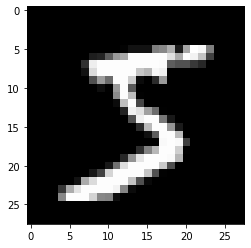

In [7]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [9]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 7, 4, 9, 3, 4, 3, 9, 8, 1, 9, 0, 9, 0, 6, 9, 2, 2, 3, 4, 0, 9, 9, 9,
        9, 7, 3, 0, 5, 4, 2, 1, 1, 9, 8, 8, 5, 1, 2, 3, 1, 4, 2, 4, 2, 3, 8, 6,
        9, 3, 6, 2, 5, 1, 8, 6, 0, 9, 3, 8, 8, 0, 3, 8, 9, 2, 8, 1, 6, 6, 4, 0,
        6, 7, 8, 9, 8, 0, 5, 6, 6, 3, 6, 4, 1, 9, 2, 3, 7, 4, 2, 1, 5, 3, 6, 0,
        3, 1, 8, 9])


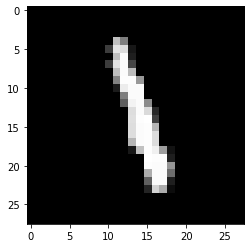

In [10]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [12]:
device

device(type='cuda')

In [14]:
image_size = 784
hidden_size = 256

In [16]:
#Discriminator model 
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()).to(device)

In [17]:
# generator model 

In [18]:
latent_size = 64

In [19]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [20]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

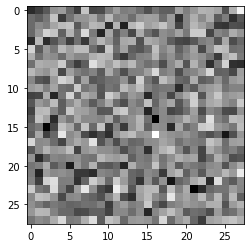

In [21]:
plt.imshow(gen_imgs[0], cmap='gray');

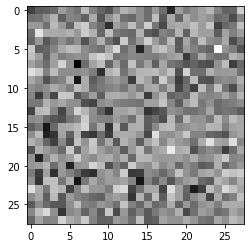

In [22]:
plt.imshow(gen_imgs[1], cmap='gray');


In [23]:
G.to(device);

In [24]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [25]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [26]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [28]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)      # using 1 as target 
    g_loss = criterion(D(fake_images), labels)         # Discriminator weights will be freezed here

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [32]:
# directory for saving sample images

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Saving fake_images-0000.png


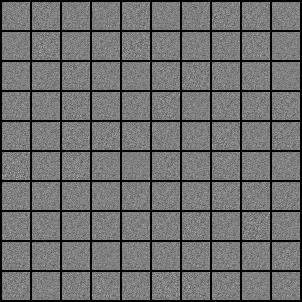

In [33]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)                 # fixing the sample vector generating same output for generator to store images         
 
def save_fake_images(index):                                               
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [35]:
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Step [200/600], d_loss: 0.0380, g_loss: 4.3763, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.0941, g_loss: 6.2312, D(x): 0.96, D(G(z)): 0.04


  0%|          | 1/300 [00:09<49:09,  9.86s/it]

Epoch [0/300], Step [600/600], d_loss: 0.0286, g_loss: 5.2463, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0841, g_loss: 4.0722, D(x): 0.98, D(G(z)): 0.06
Epoch [1/300], Step [400/600], d_loss: 0.2403, g_loss: 4.3992, D(x): 0.94, D(G(z)): 0.10


  1%|          | 2/300 [00:19<48:37,  9.79s/it]

Epoch [1/300], Step [600/600], d_loss: 0.1477, g_loss: 4.9012, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.5177, g_loss: 2.8548, D(x): 0.92, D(G(z)): 0.27
Epoch [2/300], Step [400/600], d_loss: 0.0804, g_loss: 5.0181, D(x): 0.97, D(G(z)): 0.04


  1%|          | 3/300 [00:29<48:39,  9.83s/it]

Epoch [2/300], Step [600/600], d_loss: 0.2140, g_loss: 3.8071, D(x): 0.90, D(G(z)): 0.06
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.6067, g_loss: 2.5839, D(x): 0.82, D(G(z)): 0.22
Epoch [3/300], Step [400/600], d_loss: 0.2111, g_loss: 3.3150, D(x): 0.91, D(G(z)): 0.06


  1%|▏         | 4/300 [00:39<48:38,  9.86s/it]

Epoch [3/300], Step [600/600], d_loss: 0.1526, g_loss: 3.4055, D(x): 0.96, D(G(z)): 0.09
Saving fake_images-0004.png
Epoch [4/300], Step [200/600], d_loss: 0.3831, g_loss: 2.9744, D(x): 0.88, D(G(z)): 0.11
Epoch [4/300], Step [400/600], d_loss: 0.3761, g_loss: 3.4400, D(x): 0.89, D(G(z)): 0.05


  2%|▏         | 5/300 [00:49<48:16,  9.82s/it]

Epoch [4/300], Step [600/600], d_loss: 0.1831, g_loss: 4.2521, D(x): 0.95, D(G(z)): 0.07
Saving fake_images-0005.png
Epoch [5/300], Step [200/600], d_loss: 0.1467, g_loss: 5.0996, D(x): 0.95, D(G(z)): 0.05
Epoch [5/300], Step [400/600], d_loss: 0.2082, g_loss: 4.9219, D(x): 0.93, D(G(z)): 0.03


  2%|▏         | 6/300 [00:58<48:09,  9.83s/it]

Epoch [5/300], Step [600/600], d_loss: 0.0790, g_loss: 5.6911, D(x): 0.97, D(G(z)): 0.04
Saving fake_images-0006.png
Epoch [6/300], Step [200/600], d_loss: 0.5578, g_loss: 5.1964, D(x): 0.83, D(G(z)): 0.08
Epoch [6/300], Step [400/600], d_loss: 0.3211, g_loss: 3.2307, D(x): 0.95, D(G(z)): 0.18


  2%|▏         | 7/300 [01:08<47:59,  9.83s/it]

Epoch [6/300], Step [600/600], d_loss: 0.1285, g_loss: 4.8327, D(x): 0.96, D(G(z)): 0.03
Saving fake_images-0007.png
Epoch [7/300], Step [200/600], d_loss: 0.2510, g_loss: 3.3415, D(x): 0.96, D(G(z)): 0.18
Epoch [7/300], Step [400/600], d_loss: 0.6267, g_loss: 3.1098, D(x): 0.78, D(G(z)): 0.05


  3%|▎         | 8/300 [01:18<47:42,  9.80s/it]

Epoch [7/300], Step [600/600], d_loss: 1.0541, g_loss: 2.8916, D(x): 0.76, D(G(z)): 0.05
Saving fake_images-0008.png
Epoch [8/300], Step [200/600], d_loss: 0.1179, g_loss: 5.2026, D(x): 0.96, D(G(z)): 0.04
Epoch [8/300], Step [400/600], d_loss: 0.1543, g_loss: 6.5992, D(x): 0.96, D(G(z)): 0.06


  3%|▎         | 9/300 [01:28<47:21,  9.76s/it]

Epoch [8/300], Step [600/600], d_loss: 0.1562, g_loss: 5.6302, D(x): 0.93, D(G(z)): 0.03
Saving fake_images-0009.png
Epoch [9/300], Step [200/600], d_loss: 0.4301, g_loss: 4.1574, D(x): 0.95, D(G(z)): 0.23
Epoch [9/300], Step [400/600], d_loss: 0.4027, g_loss: 3.0124, D(x): 0.89, D(G(z)): 0.15


  3%|▎         | 10/300 [01:38<47:16,  9.78s/it]

Epoch [9/300], Step [600/600], d_loss: 0.3970, g_loss: 3.8630, D(x): 0.90, D(G(z)): 0.15
Saving fake_images-0010.png
Epoch [10/300], Step [200/600], d_loss: 0.5397, g_loss: 4.5205, D(x): 0.85, D(G(z)): 0.15
Epoch [10/300], Step [400/600], d_loss: 0.3286, g_loss: 4.4224, D(x): 0.95, D(G(z)): 0.19


  4%|▎         | 11/300 [01:47<47:03,  9.77s/it]

Epoch [10/300], Step [600/600], d_loss: 0.3401, g_loss: 3.7022, D(x): 0.92, D(G(z)): 0.13
Saving fake_images-0011.png
Epoch [11/300], Step [200/600], d_loss: 0.2087, g_loss: 5.4213, D(x): 0.93, D(G(z)): 0.03
Epoch [11/300], Step [400/600], d_loss: 0.3400, g_loss: 3.3806, D(x): 0.91, D(G(z)): 0.14


  4%|▍         | 12/300 [01:57<46:53,  9.77s/it]

Epoch [11/300], Step [600/600], d_loss: 0.3412, g_loss: 3.4869, D(x): 0.90, D(G(z)): 0.11
Saving fake_images-0012.png
Epoch [12/300], Step [200/600], d_loss: 0.3621, g_loss: 5.3470, D(x): 0.93, D(G(z)): 0.11
Epoch [12/300], Step [400/600], d_loss: 0.5168, g_loss: 3.6040, D(x): 0.83, D(G(z)): 0.04


  4%|▍         | 13/300 [02:07<46:50,  9.79s/it]

Epoch [12/300], Step [600/600], d_loss: 0.3495, g_loss: 4.3450, D(x): 0.86, D(G(z)): 0.03
Saving fake_images-0013.png
Epoch [13/300], Step [200/600], d_loss: 0.2935, g_loss: 4.1479, D(x): 0.90, D(G(z)): 0.03
Epoch [13/300], Step [400/600], d_loss: 0.2186, g_loss: 3.9553, D(x): 0.91, D(G(z)): 0.07


  5%|▍         | 14/300 [02:17<46:43,  9.80s/it]

Epoch [13/300], Step [600/600], d_loss: 0.4958, g_loss: 5.1790, D(x): 0.82, D(G(z)): 0.02
Saving fake_images-0014.png
Epoch [14/300], Step [200/600], d_loss: 0.1544, g_loss: 4.2147, D(x): 0.93, D(G(z)): 0.05
Epoch [14/300], Step [400/600], d_loss: 0.1911, g_loss: 4.8163, D(x): 0.93, D(G(z)): 0.07


  5%|▌         | 15/300 [02:27<46:40,  9.83s/it]

Epoch [14/300], Step [600/600], d_loss: 0.1741, g_loss: 4.7612, D(x): 0.94, D(G(z)): 0.02
Saving fake_images-0015.png
Epoch [15/300], Step [200/600], d_loss: 0.2249, g_loss: 5.0628, D(x): 0.96, D(G(z)): 0.10
Epoch [15/300], Step [400/600], d_loss: 0.1012, g_loss: 4.6519, D(x): 0.96, D(G(z)): 0.03


  5%|▌         | 16/300 [02:36<46:27,  9.82s/it]

Epoch [15/300], Step [600/600], d_loss: 0.2466, g_loss: 3.9023, D(x): 0.92, D(G(z)): 0.06
Saving fake_images-0016.png
Epoch [16/300], Step [200/600], d_loss: 0.4035, g_loss: 3.4683, D(x): 0.87, D(G(z)): 0.08
Epoch [16/300], Step [400/600], d_loss: 0.2904, g_loss: 3.1206, D(x): 0.89, D(G(z)): 0.06


  6%|▌         | 17/300 [02:46<46:15,  9.81s/it]

Epoch [16/300], Step [600/600], d_loss: 0.2723, g_loss: 5.5514, D(x): 0.95, D(G(z)): 0.14
Saving fake_images-0017.png
Epoch [17/300], Step [200/600], d_loss: 0.2568, g_loss: 3.6162, D(x): 0.93, D(G(z)): 0.06
Epoch [17/300], Step [400/600], d_loss: 0.2897, g_loss: 4.7276, D(x): 0.92, D(G(z)): 0.03


  6%|▌         | 18/300 [02:56<45:58,  9.78s/it]

Epoch [17/300], Step [600/600], d_loss: 0.1488, g_loss: 4.8518, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0018.png
Epoch [18/300], Step [200/600], d_loss: 0.3614, g_loss: 6.0782, D(x): 0.86, D(G(z)): 0.01
Epoch [18/300], Step [400/600], d_loss: 0.2161, g_loss: 5.8502, D(x): 0.94, D(G(z)): 0.08


  6%|▋         | 19/300 [03:06<45:43,  9.76s/it]

Epoch [18/300], Step [600/600], d_loss: 0.2790, g_loss: 5.0585, D(x): 0.90, D(G(z)): 0.07
Saving fake_images-0019.png
Epoch [19/300], Step [200/600], d_loss: 0.5180, g_loss: 5.3456, D(x): 0.85, D(G(z)): 0.05
Epoch [19/300], Step [400/600], d_loss: 0.3239, g_loss: 4.6451, D(x): 0.91, D(G(z)): 0.06


  7%|▋         | 20/300 [03:15<45:38,  9.78s/it]

Epoch [19/300], Step [600/600], d_loss: 0.2336, g_loss: 4.6832, D(x): 0.92, D(G(z)): 0.04
Saving fake_images-0020.png
Epoch [20/300], Step [200/600], d_loss: 0.2522, g_loss: 4.0994, D(x): 0.94, D(G(z)): 0.11
Epoch [20/300], Step [400/600], d_loss: 0.3449, g_loss: 4.0186, D(x): 0.89, D(G(z)): 0.09


  7%|▋         | 21/300 [03:25<45:24,  9.76s/it]

Epoch [20/300], Step [600/600], d_loss: 0.3243, g_loss: 3.4781, D(x): 0.90, D(G(z)): 0.09
Saving fake_images-0021.png
Epoch [21/300], Step [200/600], d_loss: 0.3525, g_loss: 3.8642, D(x): 0.89, D(G(z)): 0.12
Epoch [21/300], Step [400/600], d_loss: 0.2951, g_loss: 3.9276, D(x): 0.90, D(G(z)): 0.05


  7%|▋         | 22/300 [03:35<45:12,  9.76s/it]

Epoch [21/300], Step [600/600], d_loss: 0.3173, g_loss: 3.5396, D(x): 0.92, D(G(z)): 0.09
Saving fake_images-0022.png
Epoch [22/300], Step [200/600], d_loss: 0.4987, g_loss: 2.9514, D(x): 0.93, D(G(z)): 0.23
Epoch [22/300], Step [400/600], d_loss: 0.1366, g_loss: 5.3873, D(x): 0.96, D(G(z)): 0.05


  8%|▊         | 23/300 [03:45<45:01,  9.75s/it]

Epoch [22/300], Step [600/600], d_loss: 0.2436, g_loss: 3.9523, D(x): 0.92, D(G(z)): 0.06
Saving fake_images-0023.png
Epoch [23/300], Step [200/600], d_loss: 0.1675, g_loss: 5.0254, D(x): 0.94, D(G(z)): 0.07
Epoch [23/300], Step [400/600], d_loss: 0.2245, g_loss: 4.6094, D(x): 0.91, D(G(z)): 0.05


  8%|▊         | 24/300 [03:55<45:01,  9.79s/it]

Epoch [23/300], Step [600/600], d_loss: 0.3972, g_loss: 4.1953, D(x): 0.91, D(G(z)): 0.13
Saving fake_images-0024.png
Epoch [24/300], Step [200/600], d_loss: 0.6840, g_loss: 5.4240, D(x): 0.95, D(G(z)): 0.26
Epoch [24/300], Step [400/600], d_loss: 0.3925, g_loss: 4.7050, D(x): 0.92, D(G(z)): 0.15


  8%|▊         | 25/300 [04:04<44:45,  9.77s/it]

Epoch [24/300], Step [600/600], d_loss: 0.1941, g_loss: 6.0314, D(x): 0.96, D(G(z)): 0.08
Saving fake_images-0025.png
Epoch [25/300], Step [200/600], d_loss: 0.2981, g_loss: 3.0802, D(x): 0.92, D(G(z)): 0.11
Epoch [25/300], Step [400/600], d_loss: 0.2769, g_loss: 4.6052, D(x): 0.92, D(G(z)): 0.10


  9%|▊         | 26/300 [04:14<44:38,  9.78s/it]

Epoch [25/300], Step [600/600], d_loss: 0.3550, g_loss: 4.7268, D(x): 0.90, D(G(z)): 0.12
Saving fake_images-0026.png
Epoch [26/300], Step [200/600], d_loss: 0.3111, g_loss: 3.4503, D(x): 0.91, D(G(z)): 0.12
Epoch [26/300], Step [400/600], d_loss: 0.4751, g_loss: 3.4034, D(x): 0.92, D(G(z)): 0.16


  9%|▉         | 27/300 [04:24<44:37,  9.81s/it]

Epoch [26/300], Step [600/600], d_loss: 0.3030, g_loss: 3.8756, D(x): 0.92, D(G(z)): 0.12
Saving fake_images-0027.png
Epoch [27/300], Step [200/600], d_loss: 0.4066, g_loss: 5.4538, D(x): 0.94, D(G(z)): 0.15
Epoch [27/300], Step [400/600], d_loss: 0.7485, g_loss: 3.7102, D(x): 0.94, D(G(z)): 0.36


  9%|▉         | 28/300 [04:34<44:25,  9.80s/it]

Epoch [27/300], Step [600/600], d_loss: 0.4007, g_loss: 3.5785, D(x): 0.86, D(G(z)): 0.08
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.3803, g_loss: 3.9104, D(x): 0.88, D(G(z)): 0.09
Epoch [28/300], Step [400/600], d_loss: 0.2263, g_loss: 4.0194, D(x): 0.91, D(G(z)): 0.08


 10%|▉         | 29/300 [04:43<44:07,  9.77s/it]

Epoch [28/300], Step [600/600], d_loss: 0.2469, g_loss: 4.0032, D(x): 0.92, D(G(z)): 0.09
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4364, g_loss: 4.7402, D(x): 0.87, D(G(z)): 0.05
Epoch [29/300], Step [400/600], d_loss: 0.3275, g_loss: 4.3414, D(x): 0.92, D(G(z)): 0.11


 10%|█         | 30/300 [04:53<44:02,  9.79s/it]

Epoch [29/300], Step [600/600], d_loss: 0.2358, g_loss: 5.4853, D(x): 0.89, D(G(z)): 0.04
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.1511, g_loss: 5.3535, D(x): 0.94, D(G(z)): 0.04
Epoch [30/300], Step [400/600], d_loss: 0.2536, g_loss: 3.6644, D(x): 0.95, D(G(z)): 0.11


 10%|█         | 31/300 [05:03<43:54,  9.80s/it]

Epoch [30/300], Step [600/600], d_loss: 0.3094, g_loss: 4.8554, D(x): 0.88, D(G(z)): 0.07
Saving fake_images-0031.png
Epoch [31/300], Step [200/600], d_loss: 0.3343, g_loss: 4.5240, D(x): 0.91, D(G(z)): 0.08
Epoch [31/300], Step [400/600], d_loss: 0.1374, g_loss: 3.7178, D(x): 0.96, D(G(z)): 0.07


 11%|█         | 32/300 [05:13<43:49,  9.81s/it]

Epoch [31/300], Step [600/600], d_loss: 0.1820, g_loss: 5.0024, D(x): 0.93, D(G(z)): 0.05
Saving fake_images-0032.png
Epoch [32/300], Step [200/600], d_loss: 0.3719, g_loss: 4.2917, D(x): 0.93, D(G(z)): 0.13
Epoch [32/300], Step [400/600], d_loss: 0.4013, g_loss: 3.2108, D(x): 0.94, D(G(z)): 0.18


 11%|█         | 33/300 [05:23<43:34,  9.79s/it]

Epoch [32/300], Step [600/600], d_loss: 0.4133, g_loss: 2.8986, D(x): 0.90, D(G(z)): 0.13
Saving fake_images-0033.png
Epoch [33/300], Step [200/600], d_loss: 0.3509, g_loss: 3.3436, D(x): 0.95, D(G(z)): 0.18
Epoch [33/300], Step [400/600], d_loss: 0.3123, g_loss: 3.2162, D(x): 0.92, D(G(z)): 0.14


 11%|█▏        | 34/300 [05:32<43:28,  9.81s/it]

Epoch [33/300], Step [600/600], d_loss: 0.2490, g_loss: 4.2753, D(x): 0.91, D(G(z)): 0.07
Saving fake_images-0034.png
Epoch [34/300], Step [200/600], d_loss: 0.5322, g_loss: 3.1521, D(x): 0.82, D(G(z)): 0.10
Epoch [34/300], Step [400/600], d_loss: 0.3673, g_loss: 4.4787, D(x): 0.87, D(G(z)): 0.09


 12%|█▏        | 35/300 [05:42<43:18,  9.81s/it]

Epoch [34/300], Step [600/600], d_loss: 0.4678, g_loss: 3.4363, D(x): 0.89, D(G(z)): 0.15
Saving fake_images-0035.png
Epoch [35/300], Step [200/600], d_loss: 0.4874, g_loss: 3.4412, D(x): 0.84, D(G(z)): 0.14
Epoch [35/300], Step [400/600], d_loss: 0.5594, g_loss: 2.8490, D(x): 0.81, D(G(z)): 0.12


 12%|█▏        | 36/300 [05:52<43:17,  9.84s/it]

Epoch [35/300], Step [600/600], d_loss: 0.5444, g_loss: 2.1454, D(x): 0.85, D(G(z)): 0.18
Saving fake_images-0036.png
Epoch [36/300], Step [200/600], d_loss: 0.3477, g_loss: 3.1725, D(x): 0.90, D(G(z)): 0.13
Epoch [36/300], Step [400/600], d_loss: 0.3742, g_loss: 2.6422, D(x): 0.90, D(G(z)): 0.13


 12%|█▏        | 37/300 [06:02<43:03,  9.82s/it]

Epoch [36/300], Step [600/600], d_loss: 0.5728, g_loss: 4.2537, D(x): 0.85, D(G(z)): 0.18
Saving fake_images-0037.png
Epoch [37/300], Step [200/600], d_loss: 0.4467, g_loss: 3.7250, D(x): 0.86, D(G(z)): 0.13
Epoch [37/300], Step [400/600], d_loss: 0.6015, g_loss: 2.8007, D(x): 0.88, D(G(z)): 0.24


 13%|█▎        | 38/300 [06:12<42:45,  9.79s/it]

Epoch [37/300], Step [600/600], d_loss: 0.6818, g_loss: 2.7824, D(x): 0.88, D(G(z)): 0.26
Saving fake_images-0038.png
Epoch [38/300], Step [200/600], d_loss: 0.2738, g_loss: 3.2458, D(x): 0.88, D(G(z)): 0.06
Epoch [38/300], Step [400/600], d_loss: 0.5737, g_loss: 3.5461, D(x): 0.90, D(G(z)): 0.18


 13%|█▎        | 39/300 [06:22<42:35,  9.79s/it]

Epoch [38/300], Step [600/600], d_loss: 0.3642, g_loss: 3.5699, D(x): 0.93, D(G(z)): 0.15
Saving fake_images-0039.png
Epoch [39/300], Step [200/600], d_loss: 0.5607, g_loss: 5.3481, D(x): 0.82, D(G(z)): 0.11
Epoch [39/300], Step [400/600], d_loss: 0.3890, g_loss: 3.2611, D(x): 0.90, D(G(z)): 0.14


 13%|█▎        | 40/300 [06:31<42:24,  9.79s/it]

Epoch [39/300], Step [600/600], d_loss: 0.4206, g_loss: 3.9444, D(x): 0.89, D(G(z)): 0.15
Saving fake_images-0040.png
Epoch [40/300], Step [200/600], d_loss: 0.2986, g_loss: 4.5483, D(x): 0.90, D(G(z)): 0.09
Epoch [40/300], Step [400/600], d_loss: 0.3260, g_loss: 3.4434, D(x): 0.93, D(G(z)): 0.15


 14%|█▎        | 41/300 [06:41<42:18,  9.80s/it]

Epoch [40/300], Step [600/600], d_loss: 0.3191, g_loss: 3.6883, D(x): 0.86, D(G(z)): 0.07
Saving fake_images-0041.png
Epoch [41/300], Step [200/600], d_loss: 0.5910, g_loss: 2.8801, D(x): 0.79, D(G(z)): 0.08
Epoch [41/300], Step [400/600], d_loss: 0.4873, g_loss: 2.6833, D(x): 0.83, D(G(z)): 0.11


 14%|█▍        | 42/300 [06:51<42:06,  9.79s/it]

Epoch [41/300], Step [600/600], d_loss: 0.4971, g_loss: 2.8455, D(x): 0.87, D(G(z)): 0.18
Saving fake_images-0042.png
Epoch [42/300], Step [200/600], d_loss: 0.3088, g_loss: 3.2293, D(x): 0.92, D(G(z)): 0.14
Epoch [42/300], Step [400/600], d_loss: 0.4964, g_loss: 2.8468, D(x): 0.82, D(G(z)): 0.13


 14%|█▍        | 43/300 [07:01<41:50,  9.77s/it]

Epoch [42/300], Step [600/600], d_loss: 0.4978, g_loss: 2.6971, D(x): 0.90, D(G(z)): 0.20
Saving fake_images-0043.png
Epoch [43/300], Step [200/600], d_loss: 0.4870, g_loss: 3.0499, D(x): 0.89, D(G(z)): 0.19
Epoch [43/300], Step [400/600], d_loss: 0.6581, g_loss: 3.5376, D(x): 0.78, D(G(z)): 0.15


 15%|█▍        | 44/300 [07:10<41:44,  9.79s/it]

Epoch [43/300], Step [600/600], d_loss: 0.6717, g_loss: 3.5030, D(x): 0.86, D(G(z)): 0.23
Saving fake_images-0044.png
Epoch [44/300], Step [200/600], d_loss: 0.4402, g_loss: 3.3622, D(x): 0.86, D(G(z)): 0.15
Epoch [44/300], Step [400/600], d_loss: 0.5223, g_loss: 2.2743, D(x): 0.82, D(G(z)): 0.16


 15%|█▌        | 45/300 [07:20<41:36,  9.79s/it]

Epoch [44/300], Step [600/600], d_loss: 0.7264, g_loss: 3.6288, D(x): 0.72, D(G(z)): 0.09
Saving fake_images-0045.png
Epoch [45/300], Step [200/600], d_loss: 0.5781, g_loss: 3.2676, D(x): 0.77, D(G(z)): 0.10
Epoch [45/300], Step [400/600], d_loss: 0.5668, g_loss: 2.9666, D(x): 0.83, D(G(z)): 0.18


 15%|█▌        | 46/300 [07:30<41:17,  9.75s/it]

Epoch [45/300], Step [600/600], d_loss: 0.5925, g_loss: 3.4797, D(x): 0.85, D(G(z)): 0.24
Saving fake_images-0046.png
Epoch [46/300], Step [200/600], d_loss: 0.4758, g_loss: 2.2076, D(x): 0.87, D(G(z)): 0.20
Epoch [46/300], Step [400/600], d_loss: 0.5755, g_loss: 2.4226, D(x): 0.85, D(G(z)): 0.22


 16%|█▌        | 47/300 [07:40<41:02,  9.73s/it]

Epoch [46/300], Step [600/600], d_loss: 0.6463, g_loss: 3.1785, D(x): 0.75, D(G(z)): 0.09
Saving fake_images-0047.png
Epoch [47/300], Step [200/600], d_loss: 0.5013, g_loss: 3.1777, D(x): 0.78, D(G(z)): 0.07
Epoch [47/300], Step [400/600], d_loss: 0.6671, g_loss: 3.5823, D(x): 0.75, D(G(z)): 0.11


 16%|█▌        | 48/300 [07:49<40:57,  9.75s/it]

Epoch [47/300], Step [600/600], d_loss: 0.4670, g_loss: 3.4155, D(x): 0.87, D(G(z)): 0.15
Saving fake_images-0048.png
Epoch [48/300], Step [200/600], d_loss: 0.3249, g_loss: 3.0218, D(x): 0.87, D(G(z)): 0.11
Epoch [48/300], Step [400/600], d_loss: 0.2510, g_loss: 3.7743, D(x): 0.89, D(G(z)): 0.08


 16%|█▋        | 49/300 [07:59<40:49,  9.76s/it]

Epoch [48/300], Step [600/600], d_loss: 0.4664, g_loss: 3.8996, D(x): 0.87, D(G(z)): 0.15
Saving fake_images-0049.png
Epoch [49/300], Step [200/600], d_loss: 0.2051, g_loss: 4.1003, D(x): 0.93, D(G(z)): 0.09
Epoch [49/300], Step [400/600], d_loss: 0.2326, g_loss: 4.6874, D(x): 0.91, D(G(z)): 0.06


 17%|█▋        | 50/300 [08:09<40:29,  9.72s/it]

Epoch [49/300], Step [600/600], d_loss: 0.3280, g_loss: 4.6498, D(x): 0.88, D(G(z)): 0.10
Saving fake_images-0050.png
Epoch [50/300], Step [200/600], d_loss: 0.2834, g_loss: 3.0614, D(x): 0.92, D(G(z)): 0.10
Epoch [50/300], Step [400/600], d_loss: 0.5343, g_loss: 2.3249, D(x): 0.82, D(G(z)): 0.15


 17%|█▋        | 51/300 [08:19<40:24,  9.74s/it]

Epoch [50/300], Step [600/600], d_loss: 0.5545, g_loss: 4.2046, D(x): 0.79, D(G(z)): 0.12
Saving fake_images-0051.png
Epoch [51/300], Step [200/600], d_loss: 0.4588, g_loss: 2.5461, D(x): 0.85, D(G(z)): 0.12
Epoch [51/300], Step [400/600], d_loss: 0.5017, g_loss: 2.7998, D(x): 0.80, D(G(z)): 0.13


 17%|█▋        | 52/300 [08:28<40:11,  9.72s/it]

Epoch [51/300], Step [600/600], d_loss: 0.4220, g_loss: 2.3963, D(x): 0.84, D(G(z)): 0.07
Saving fake_images-0052.png
Epoch [52/300], Step [200/600], d_loss: 0.5650, g_loss: 3.0468, D(x): 0.81, D(G(z)): 0.12
Epoch [52/300], Step [400/600], d_loss: 0.5526, g_loss: 3.0168, D(x): 0.86, D(G(z)): 0.22


 18%|█▊        | 53/300 [08:38<39:55,  9.70s/it]

Epoch [52/300], Step [600/600], d_loss: 0.4973, g_loss: 2.8915, D(x): 0.82, D(G(z)): 0.13
Saving fake_images-0053.png
Epoch [53/300], Step [200/600], d_loss: 0.7017, g_loss: 2.3581, D(x): 0.84, D(G(z)): 0.25
Epoch [53/300], Step [400/600], d_loss: 0.7836, g_loss: 2.3000, D(x): 0.73, D(G(z)): 0.19


 18%|█▊        | 54/300 [08:48<39:55,  9.74s/it]

Epoch [53/300], Step [600/600], d_loss: 0.6651, g_loss: 1.8157, D(x): 0.83, D(G(z)): 0.27
Saving fake_images-0054.png
Epoch [54/300], Step [200/600], d_loss: 0.5759, g_loss: 2.5640, D(x): 0.77, D(G(z)): 0.14
Epoch [54/300], Step [400/600], d_loss: 0.8009, g_loss: 2.3618, D(x): 0.70, D(G(z)): 0.16


 18%|█▊        | 55/300 [08:58<39:51,  9.76s/it]

Epoch [54/300], Step [600/600], d_loss: 0.5935, g_loss: 2.3007, D(x): 0.87, D(G(z)): 0.27
Saving fake_images-0055.png
Epoch [55/300], Step [200/600], d_loss: 0.6346, g_loss: 2.6527, D(x): 0.82, D(G(z)): 0.22
Epoch [55/300], Step [400/600], d_loss: 0.6470, g_loss: 2.3945, D(x): 0.80, D(G(z)): 0.21


 19%|█▊        | 56/300 [09:07<39:40,  9.76s/it]

Epoch [55/300], Step [600/600], d_loss: 0.5923, g_loss: 3.0205, D(x): 0.80, D(G(z)): 0.15
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.7232, g_loss: 2.4242, D(x): 0.80, D(G(z)): 0.24
Epoch [56/300], Step [400/600], d_loss: 0.5529, g_loss: 2.4601, D(x): 0.87, D(G(z)): 0.26


 19%|█▉        | 57/300 [09:17<39:37,  9.79s/it]

Epoch [56/300], Step [600/600], d_loss: 0.6286, g_loss: 2.3292, D(x): 0.79, D(G(z)): 0.20
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6454, g_loss: 2.0825, D(x): 0.81, D(G(z)): 0.24
Epoch [57/300], Step [400/600], d_loss: 0.6867, g_loss: 1.7861, D(x): 0.77, D(G(z)): 0.21


 19%|█▉        | 58/300 [09:27<39:29,  9.79s/it]

Epoch [57/300], Step [600/600], d_loss: 0.5330, g_loss: 2.2132, D(x): 0.85, D(G(z)): 0.19
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 1.0272, g_loss: 1.6260, D(x): 0.73, D(G(z)): 0.31
Epoch [58/300], Step [400/600], d_loss: 0.6158, g_loss: 2.4890, D(x): 0.76, D(G(z)): 0.17


 20%|█▉        | 59/300 [09:37<39:07,  9.74s/it]

Epoch [58/300], Step [600/600], d_loss: 0.5849, g_loss: 2.3074, D(x): 0.80, D(G(z)): 0.19
Saving fake_images-0059.png
Epoch [59/300], Step [200/600], d_loss: 0.5241, g_loss: 2.9642, D(x): 0.80, D(G(z)): 0.16
Epoch [59/300], Step [400/600], d_loss: 0.5729, g_loss: 2.6006, D(x): 0.83, D(G(z)): 0.22


 20%|██        | 60/300 [09:46<38:52,  9.72s/it]

Epoch [59/300], Step [600/600], d_loss: 0.8398, g_loss: 2.1478, D(x): 0.77, D(G(z)): 0.25
Saving fake_images-0060.png
Epoch [60/300], Step [200/600], d_loss: 0.6697, g_loss: 2.8542, D(x): 0.73, D(G(z)): 0.12
Epoch [60/300], Step [400/600], d_loss: 0.7558, g_loss: 2.1534, D(x): 0.75, D(G(z)): 0.19


 20%|██        | 61/300 [09:56<38:46,  9.73s/it]

Epoch [60/300], Step [600/600], d_loss: 0.5185, g_loss: 3.1093, D(x): 0.86, D(G(z)): 0.21
Saving fake_images-0061.png
Epoch [61/300], Step [200/600], d_loss: 0.5343, g_loss: 2.9083, D(x): 0.84, D(G(z)): 0.17
Epoch [61/300], Step [400/600], d_loss: 0.4833, g_loss: 2.8763, D(x): 0.86, D(G(z)): 0.17


 21%|██        | 62/300 [10:06<38:34,  9.73s/it]

Epoch [61/300], Step [600/600], d_loss: 0.5528, g_loss: 2.7852, D(x): 0.81, D(G(z)): 0.17
Saving fake_images-0062.png
Epoch [62/300], Step [200/600], d_loss: 0.6523, g_loss: 2.7592, D(x): 0.73, D(G(z)): 0.10
Epoch [62/300], Step [400/600], d_loss: 0.4893, g_loss: 3.4394, D(x): 0.93, D(G(z)): 0.25


 21%|██        | 63/300 [10:15<38:18,  9.70s/it]

Epoch [62/300], Step [600/600], d_loss: 0.4845, g_loss: 2.6160, D(x): 0.77, D(G(z)): 0.07
Saving fake_images-0063.png
Epoch [63/300], Step [200/600], d_loss: 0.5169, g_loss: 3.3002, D(x): 0.82, D(G(z)): 0.15
Epoch [63/300], Step [400/600], d_loss: 0.5741, g_loss: 2.2625, D(x): 0.85, D(G(z)): 0.23


 21%|██▏       | 64/300 [10:25<38:15,  9.73s/it]

Epoch [63/300], Step [600/600], d_loss: 0.7412, g_loss: 2.9641, D(x): 0.77, D(G(z)): 0.20
Saving fake_images-0064.png
Epoch [64/300], Step [200/600], d_loss: 0.7053, g_loss: 2.5213, D(x): 0.77, D(G(z)): 0.21
Epoch [64/300], Step [400/600], d_loss: 0.5406, g_loss: 2.7599, D(x): 0.82, D(G(z)): 0.15


 22%|██▏       | 65/300 [10:35<38:14,  9.77s/it]

Epoch [64/300], Step [600/600], d_loss: 0.5143, g_loss: 2.8782, D(x): 0.82, D(G(z)): 0.16
Saving fake_images-0065.png
Epoch [65/300], Step [200/600], d_loss: 0.8096, g_loss: 2.3990, D(x): 0.79, D(G(z)): 0.28
Epoch [65/300], Step [400/600], d_loss: 0.6589, g_loss: 1.9417, D(x): 0.75, D(G(z)): 0.17


 22%|██▏       | 66/300 [10:45<38:03,  9.76s/it]

Epoch [65/300], Step [600/600], d_loss: 0.7013, g_loss: 2.2252, D(x): 0.76, D(G(z)): 0.20
Saving fake_images-0066.png
Epoch [66/300], Step [200/600], d_loss: 0.6273, g_loss: 2.7908, D(x): 0.84, D(G(z)): 0.26
Epoch [66/300], Step [400/600], d_loss: 0.7642, g_loss: 2.4260, D(x): 0.83, D(G(z)): 0.29


 22%|██▏       | 67/300 [10:55<37:58,  9.78s/it]

Epoch [66/300], Step [600/600], d_loss: 0.5894, g_loss: 1.9538, D(x): 0.83, D(G(z)): 0.23
Saving fake_images-0067.png
Epoch [67/300], Step [200/600], d_loss: 0.7038, g_loss: 2.0013, D(x): 0.81, D(G(z)): 0.28
Epoch [67/300], Step [400/600], d_loss: 0.5733, g_loss: 2.6147, D(x): 0.78, D(G(z)): 0.18


 23%|██▎       | 68/300 [11:04<37:56,  9.81s/it]

Epoch [67/300], Step [600/600], d_loss: 1.0217, g_loss: 1.7610, D(x): 0.68, D(G(z)): 0.24
Saving fake_images-0068.png
Epoch [68/300], Step [200/600], d_loss: 0.6637, g_loss: 2.6642, D(x): 0.77, D(G(z)): 0.24
Epoch [68/300], Step [400/600], d_loss: 0.7308, g_loss: 2.3732, D(x): 0.69, D(G(z)): 0.13


 23%|██▎       | 69/300 [11:14<37:36,  9.77s/it]

Epoch [68/300], Step [600/600], d_loss: 0.6445, g_loss: 2.1317, D(x): 0.79, D(G(z)): 0.22
Saving fake_images-0069.png
Epoch [69/300], Step [200/600], d_loss: 0.9486, g_loss: 1.5497, D(x): 0.72, D(G(z)): 0.31
Epoch [69/300], Step [400/600], d_loss: 0.6240, g_loss: 1.9384, D(x): 0.85, D(G(z)): 0.28


 23%|██▎       | 70/300 [11:24<37:21,  9.74s/it]

Epoch [69/300], Step [600/600], d_loss: 0.9457, g_loss: 2.0259, D(x): 0.68, D(G(z)): 0.25
Saving fake_images-0070.png
Epoch [70/300], Step [200/600], d_loss: 0.8205, g_loss: 1.7687, D(x): 0.72, D(G(z)): 0.25
Epoch [70/300], Step [400/600], d_loss: 0.6659, g_loss: 2.3708, D(x): 0.76, D(G(z)): 0.22


 24%|██▎       | 71/300 [11:34<37:14,  9.76s/it]

Epoch [70/300], Step [600/600], d_loss: 0.7364, g_loss: 2.0064, D(x): 0.74, D(G(z)): 0.20
Saving fake_images-0071.png
Epoch [71/300], Step [200/600], d_loss: 0.7716, g_loss: 1.6886, D(x): 0.81, D(G(z)): 0.30
Epoch [71/300], Step [400/600], d_loss: 0.6700, g_loss: 2.0112, D(x): 0.83, D(G(z)): 0.30


 24%|██▍       | 72/300 [11:43<37:04,  9.76s/it]

Epoch [71/300], Step [600/600], d_loss: 0.7646, g_loss: 1.6149, D(x): 0.77, D(G(z)): 0.27
Saving fake_images-0072.png
Epoch [72/300], Step [200/600], d_loss: 0.8145, g_loss: 2.0355, D(x): 0.66, D(G(z)): 0.17
Epoch [72/300], Step [400/600], d_loss: 0.8135, g_loss: 1.9128, D(x): 0.76, D(G(z)): 0.28


 24%|██▍       | 73/300 [11:53<36:52,  9.75s/it]

Epoch [72/300], Step [600/600], d_loss: 0.5033, g_loss: 2.6464, D(x): 0.78, D(G(z)): 0.12
Saving fake_images-0073.png
Epoch [73/300], Step [200/600], d_loss: 0.6227, g_loss: 2.0662, D(x): 0.80, D(G(z)): 0.20
Epoch [73/300], Step [400/600], d_loss: 0.7969, g_loss: 2.2115, D(x): 0.82, D(G(z)): 0.32


 25%|██▍       | 74/300 [12:03<36:41,  9.74s/it]

Epoch [73/300], Step [600/600], d_loss: 0.6186, g_loss: 2.6316, D(x): 0.81, D(G(z)): 0.24
Saving fake_images-0074.png
Epoch [74/300], Step [200/600], d_loss: 0.7393, g_loss: 2.4014, D(x): 0.88, D(G(z)): 0.35
Epoch [74/300], Step [400/600], d_loss: 0.5963, g_loss: 2.4099, D(x): 0.82, D(G(z)): 0.19


 25%|██▌       | 75/300 [12:13<36:30,  9.73s/it]

Epoch [74/300], Step [600/600], d_loss: 0.4976, g_loss: 1.9941, D(x): 0.85, D(G(z)): 0.19
Saving fake_images-0075.png
Epoch [75/300], Step [200/600], d_loss: 0.6642, g_loss: 2.0030, D(x): 0.80, D(G(z)): 0.23
Epoch [75/300], Step [400/600], d_loss: 0.4670, g_loss: 1.8350, D(x): 0.80, D(G(z)): 0.14


 25%|██▌       | 76/300 [12:22<36:10,  9.69s/it]

Epoch [75/300], Step [600/600], d_loss: 0.7185, g_loss: 2.3794, D(x): 0.76, D(G(z)): 0.21
Saving fake_images-0076.png
Epoch [76/300], Step [200/600], d_loss: 0.4671, g_loss: 2.6916, D(x): 0.88, D(G(z)): 0.22
Epoch [76/300], Step [400/600], d_loss: 0.7990, g_loss: 1.6442, D(x): 0.73, D(G(z)): 0.26


 26%|██▌       | 77/300 [12:32<35:51,  9.65s/it]

Epoch [76/300], Step [600/600], d_loss: 0.7025, g_loss: 1.9867, D(x): 0.77, D(G(z)): 0.23
Saving fake_images-0077.png
Epoch [77/300], Step [200/600], d_loss: 0.6175, g_loss: 2.3060, D(x): 0.76, D(G(z)): 0.19
Epoch [77/300], Step [400/600], d_loss: 0.6583, g_loss: 2.4304, D(x): 0.78, D(G(z)): 0.22


 26%|██▌       | 78/300 [12:41<35:46,  9.67s/it]

Epoch [77/300], Step [600/600], d_loss: 0.6370, g_loss: 3.0096, D(x): 0.81, D(G(z)): 0.20
Saving fake_images-0078.png
Epoch [78/300], Step [200/600], d_loss: 0.6351, g_loss: 2.4010, D(x): 0.75, D(G(z)): 0.16
Epoch [78/300], Step [400/600], d_loss: 0.8512, g_loss: 2.0989, D(x): 0.77, D(G(z)): 0.28


 26%|██▋       | 79/300 [12:51<35:34,  9.66s/it]

Epoch [78/300], Step [600/600], d_loss: 0.7943, g_loss: 1.9207, D(x): 0.76, D(G(z)): 0.27
Saving fake_images-0079.png
Epoch [79/300], Step [200/600], d_loss: 0.6954, g_loss: 2.1020, D(x): 0.81, D(G(z)): 0.28
Epoch [79/300], Step [400/600], d_loss: 0.7130, g_loss: 2.8445, D(x): 0.78, D(G(z)): 0.24


 27%|██▋       | 80/300 [13:01<35:33,  9.70s/it]

Epoch [79/300], Step [600/600], d_loss: 0.6953, g_loss: 1.9889, D(x): 0.87, D(G(z)): 0.31
Saving fake_images-0080.png
Epoch [80/300], Step [200/600], d_loss: 0.5967, g_loss: 2.5723, D(x): 0.77, D(G(z)): 0.19
Epoch [80/300], Step [400/600], d_loss: 0.6675, g_loss: 2.1805, D(x): 0.88, D(G(z)): 0.33


 27%|██▋       | 81/300 [13:11<35:35,  9.75s/it]

Epoch [80/300], Step [600/600], d_loss: 0.7403, g_loss: 2.5256, D(x): 0.78, D(G(z)): 0.25
Saving fake_images-0081.png
Epoch [81/300], Step [200/600], d_loss: 0.7044, g_loss: 2.0578, D(x): 0.78, D(G(z)): 0.24
Epoch [81/300], Step [400/600], d_loss: 0.7367, g_loss: 2.2563, D(x): 0.76, D(G(z)): 0.19


 27%|██▋       | 82/300 [13:21<35:33,  9.79s/it]

Epoch [81/300], Step [600/600], d_loss: 0.7049, g_loss: 2.1001, D(x): 0.76, D(G(z)): 0.24
Saving fake_images-0082.png
Epoch [82/300], Step [200/600], d_loss: 0.6902, g_loss: 2.2327, D(x): 0.80, D(G(z)): 0.26
Epoch [82/300], Step [400/600], d_loss: 0.9243, g_loss: 1.8679, D(x): 0.80, D(G(z)): 0.38


 28%|██▊       | 83/300 [13:30<35:14,  9.74s/it]

Epoch [82/300], Step [600/600], d_loss: 0.7309, g_loss: 1.7582, D(x): 0.77, D(G(z)): 0.23
Saving fake_images-0083.png
Epoch [83/300], Step [200/600], d_loss: 0.6488, g_loss: 2.4068, D(x): 0.84, D(G(z)): 0.25
Epoch [83/300], Step [400/600], d_loss: 0.7062, g_loss: 2.1163, D(x): 0.78, D(G(z)): 0.24


 28%|██▊       | 84/300 [13:40<34:55,  9.70s/it]

Epoch [83/300], Step [600/600], d_loss: 0.5897, g_loss: 1.2186, D(x): 0.84, D(G(z)): 0.26
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.5922, g_loss: 1.7918, D(x): 0.85, D(G(z)): 0.28
Epoch [84/300], Step [400/600], d_loss: 0.7423, g_loss: 2.0694, D(x): 0.81, D(G(z)): 0.31


 28%|██▊       | 85/300 [13:49<34:47,  9.71s/it]

Epoch [84/300], Step [600/600], d_loss: 0.8714, g_loss: 1.8564, D(x): 0.74, D(G(z)): 0.30
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8121, g_loss: 1.7915, D(x): 0.70, D(G(z)): 0.20
Epoch [85/300], Step [400/600], d_loss: 0.6528, g_loss: 2.0834, D(x): 0.79, D(G(z)): 0.22


 29%|██▊       | 86/300 [13:59<34:39,  9.72s/it]

Epoch [85/300], Step [600/600], d_loss: 0.5793, g_loss: 3.3827, D(x): 0.74, D(G(z)): 0.13
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.5456, g_loss: 2.2780, D(x): 0.78, D(G(z)): 0.16
Epoch [86/300], Step [400/600], d_loss: 0.7055, g_loss: 1.9314, D(x): 0.77, D(G(z)): 0.22


 29%|██▉       | 87/300 [14:09<34:29,  9.71s/it]

Epoch [86/300], Step [600/600], d_loss: 0.9372, g_loss: 1.5553, D(x): 0.81, D(G(z)): 0.38
Saving fake_images-0087.png
Epoch [87/300], Step [200/600], d_loss: 0.8537, g_loss: 1.6595, D(x): 0.72, D(G(z)): 0.25
Epoch [87/300], Step [400/600], d_loss: 0.7200, g_loss: 2.7645, D(x): 0.74, D(G(z)): 0.22


 29%|██▉       | 88/300 [14:19<34:20,  9.72s/it]

Epoch [87/300], Step [600/600], d_loss: 0.7481, g_loss: 2.1500, D(x): 0.75, D(G(z)): 0.23
Saving fake_images-0088.png
Epoch [88/300], Step [200/600], d_loss: 0.7145, g_loss: 2.2016, D(x): 0.75, D(G(z)): 0.24
Epoch [88/300], Step [400/600], d_loss: 0.7958, g_loss: 2.3436, D(x): 0.75, D(G(z)): 0.22


 30%|██▉       | 89/300 [14:28<34:05,  9.69s/it]

Epoch [88/300], Step [600/600], d_loss: 0.7884, g_loss: 2.1315, D(x): 0.73, D(G(z)): 0.22
Saving fake_images-0089.png
Epoch [89/300], Step [200/600], d_loss: 0.8158, g_loss: 2.1668, D(x): 0.76, D(G(z)): 0.28
Epoch [89/300], Step [400/600], d_loss: 0.7402, g_loss: 1.9051, D(x): 0.86, D(G(z)): 0.35


 30%|███       | 90/300 [14:38<33:51,  9.67s/it]

Epoch [89/300], Step [600/600], d_loss: 0.8449, g_loss: 1.8297, D(x): 0.79, D(G(z)): 0.31
Saving fake_images-0090.png
Epoch [90/300], Step [200/600], d_loss: 0.7912, g_loss: 1.6028, D(x): 0.83, D(G(z)): 0.34
Epoch [90/300], Step [400/600], d_loss: 0.6734, g_loss: 1.8556, D(x): 0.79, D(G(z)): 0.26


 30%|███       | 91/300 [14:48<33:40,  9.67s/it]

Epoch [90/300], Step [600/600], d_loss: 0.6520, g_loss: 2.1965, D(x): 0.80, D(G(z)): 0.23
Saving fake_images-0091.png
Epoch [91/300], Step [200/600], d_loss: 0.9028, g_loss: 1.7881, D(x): 0.72, D(G(z)): 0.25
Epoch [91/300], Step [400/600], d_loss: 0.7050, g_loss: 2.0522, D(x): 0.75, D(G(z)): 0.20


 31%|███       | 92/300 [14:57<33:38,  9.70s/it]

Epoch [91/300], Step [600/600], d_loss: 0.4831, g_loss: 2.4644, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0092.png
Epoch [92/300], Step [200/600], d_loss: 0.8528, g_loss: 2.4555, D(x): 0.73, D(G(z)): 0.26
Epoch [92/300], Step [400/600], d_loss: 0.9119, g_loss: 2.8092, D(x): 0.66, D(G(z)): 0.14


 31%|███       | 93/300 [15:07<33:20,  9.66s/it]

Epoch [92/300], Step [600/600], d_loss: 0.8163, g_loss: 2.0483, D(x): 0.79, D(G(z)): 0.30
Saving fake_images-0093.png
Epoch [93/300], Step [200/600], d_loss: 0.7456, g_loss: 2.3486, D(x): 0.79, D(G(z)): 0.25
Epoch [93/300], Step [400/600], d_loss: 0.6001, g_loss: 2.2618, D(x): 0.79, D(G(z)): 0.19


 31%|███▏      | 94/300 [15:16<33:01,  9.62s/it]

Epoch [93/300], Step [600/600], d_loss: 0.9852, g_loss: 1.6858, D(x): 0.78, D(G(z)): 0.36
Saving fake_images-0094.png
Epoch [94/300], Step [200/600], d_loss: 0.9449, g_loss: 2.0345, D(x): 0.65, D(G(z)): 0.20
Epoch [94/300], Step [400/600], d_loss: 0.7716, g_loss: 1.8093, D(x): 0.80, D(G(z)): 0.33


 32%|███▏      | 95/300 [15:26<32:55,  9.64s/it]

Epoch [94/300], Step [600/600], d_loss: 0.9099, g_loss: 1.7374, D(x): 0.72, D(G(z)): 0.31
Saving fake_images-0095.png
Epoch [95/300], Step [200/600], d_loss: 0.6010, g_loss: 1.6303, D(x): 0.78, D(G(z)): 0.20
Epoch [95/300], Step [400/600], d_loss: 0.6292, g_loss: 2.3120, D(x): 0.77, D(G(z)): 0.18


 32%|███▏      | 96/300 [15:36<32:37,  9.59s/it]

Epoch [95/300], Step [600/600], d_loss: 0.8437, g_loss: 1.9045, D(x): 0.85, D(G(z)): 0.40
Saving fake_images-0096.png
Epoch [96/300], Step [200/600], d_loss: 0.6822, g_loss: 2.2807, D(x): 0.78, D(G(z)): 0.25
Epoch [96/300], Step [400/600], d_loss: 0.5551, g_loss: 2.2164, D(x): 0.80, D(G(z)): 0.20


 32%|███▏      | 97/300 [15:45<32:22,  9.57s/it]

Epoch [96/300], Step [600/600], d_loss: 0.8983, g_loss: 1.5759, D(x): 0.72, D(G(z)): 0.29
Saving fake_images-0097.png
Epoch [97/300], Step [200/600], d_loss: 0.9900, g_loss: 1.8609, D(x): 0.64, D(G(z)): 0.22
Epoch [97/300], Step [400/600], d_loss: 0.5920, g_loss: 2.3213, D(x): 0.80, D(G(z)): 0.21


 33%|███▎      | 98/300 [15:55<32:22,  9.62s/it]

Epoch [97/300], Step [600/600], d_loss: 0.9247, g_loss: 2.1408, D(x): 0.72, D(G(z)): 0.29
Saving fake_images-0098.png
Epoch [98/300], Step [200/600], d_loss: 0.9607, g_loss: 1.4334, D(x): 0.71, D(G(z)): 0.32
Epoch [98/300], Step [400/600], d_loss: 0.8394, g_loss: 1.8767, D(x): 0.75, D(G(z)): 0.25


 33%|███▎      | 99/300 [16:05<32:22,  9.66s/it]

Epoch [98/300], Step [600/600], d_loss: 0.9337, g_loss: 1.9896, D(x): 0.68, D(G(z)): 0.25
Saving fake_images-0099.png
Epoch [99/300], Step [200/600], d_loss: 0.7225, g_loss: 2.0780, D(x): 0.79, D(G(z)): 0.26
Epoch [99/300], Step [400/600], d_loss: 0.7364, g_loss: 1.7314, D(x): 0.76, D(G(z)): 0.26


 33%|███▎      | 100/300 [16:14<32:17,  9.69s/it]

Epoch [99/300], Step [600/600], d_loss: 0.9054, g_loss: 1.5388, D(x): 0.79, D(G(z)): 0.36
Saving fake_images-0100.png
Epoch [100/300], Step [200/600], d_loss: 0.7472, g_loss: 2.2004, D(x): 0.72, D(G(z)): 0.22
Epoch [100/300], Step [400/600], d_loss: 0.9101, g_loss: 1.9889, D(x): 0.71, D(G(z)): 0.26


 34%|███▎      | 101/300 [16:24<32:10,  9.70s/it]

Epoch [100/300], Step [600/600], d_loss: 0.8089, g_loss: 1.8937, D(x): 0.72, D(G(z)): 0.24
Saving fake_images-0101.png
Epoch [101/300], Step [200/600], d_loss: 0.6824, g_loss: 1.6913, D(x): 0.77, D(G(z)): 0.24
Epoch [101/300], Step [400/600], d_loss: 0.6700, g_loss: 2.1052, D(x): 0.79, D(G(z)): 0.24


 34%|███▍      | 102/300 [16:34<32:02,  9.71s/it]

Epoch [101/300], Step [600/600], d_loss: 0.8165, g_loss: 2.2740, D(x): 0.71, D(G(z)): 0.25
Saving fake_images-0102.png
Epoch [102/300], Step [200/600], d_loss: 0.7601, g_loss: 1.6824, D(x): 0.77, D(G(z)): 0.28
Epoch [102/300], Step [400/600], d_loss: 0.9275, g_loss: 2.1094, D(x): 0.80, D(G(z)): 0.36


 34%|███▍      | 103/300 [16:44<32:03,  9.76s/it]

Epoch [102/300], Step [600/600], d_loss: 0.9871, g_loss: 1.9285, D(x): 0.63, D(G(z)): 0.19
Saving fake_images-0103.png
Epoch [103/300], Step [200/600], d_loss: 0.9113, g_loss: 1.7362, D(x): 0.77, D(G(z)): 0.37
Epoch [103/300], Step [400/600], d_loss: 0.6599, g_loss: 1.6145, D(x): 0.77, D(G(z)): 0.22


 35%|███▍      | 104/300 [16:54<32:06,  9.83s/it]

Epoch [103/300], Step [600/600], d_loss: 0.8805, g_loss: 1.7117, D(x): 0.70, D(G(z)): 0.25
Saving fake_images-0104.png
Epoch [104/300], Step [200/600], d_loss: 0.8991, g_loss: 1.4566, D(x): 0.68, D(G(z)): 0.26
Epoch [104/300], Step [400/600], d_loss: 0.8121, g_loss: 1.8195, D(x): 0.72, D(G(z)): 0.24


 35%|███▌      | 105/300 [17:04<31:54,  9.82s/it]

Epoch [104/300], Step [600/600], d_loss: 0.9673, g_loss: 2.1172, D(x): 0.64, D(G(z)): 0.22
Saving fake_images-0105.png
Epoch [105/300], Step [200/600], d_loss: 0.9010, g_loss: 2.1010, D(x): 0.66, D(G(z)): 0.20
Epoch [105/300], Step [400/600], d_loss: 0.8769, g_loss: 1.6526, D(x): 0.81, D(G(z)): 0.36


 35%|███▌      | 106/300 [17:13<31:38,  9.79s/it]

Epoch [105/300], Step [600/600], d_loss: 1.0725, g_loss: 1.7207, D(x): 0.72, D(G(z)): 0.35
Saving fake_images-0106.png
Epoch [106/300], Step [200/600], d_loss: 0.8471, g_loss: 1.7364, D(x): 0.75, D(G(z)): 0.28
Epoch [106/300], Step [400/600], d_loss: 0.9628, g_loss: 1.6851, D(x): 0.74, D(G(z)): 0.31


 36%|███▌      | 107/300 [17:23<31:25,  9.77s/it]

Epoch [106/300], Step [600/600], d_loss: 0.6431, g_loss: 2.4260, D(x): 0.72, D(G(z)): 0.14
Saving fake_images-0107.png
Epoch [107/300], Step [200/600], d_loss: 0.7081, g_loss: 2.0670, D(x): 0.81, D(G(z)): 0.28
Epoch [107/300], Step [400/600], d_loss: 0.7734, g_loss: 1.8192, D(x): 0.76, D(G(z)): 0.25


 36%|███▌      | 108/300 [17:33<31:06,  9.72s/it]

Epoch [107/300], Step [600/600], d_loss: 0.9141, g_loss: 2.2288, D(x): 0.74, D(G(z)): 0.31
Saving fake_images-0108.png
Epoch [108/300], Step [200/600], d_loss: 0.7383, g_loss: 1.8622, D(x): 0.76, D(G(z)): 0.26
Epoch [108/300], Step [400/600], d_loss: 0.8274, g_loss: 1.7120, D(x): 0.77, D(G(z)): 0.33


 36%|███▋      | 109/300 [17:42<30:51,  9.69s/it]

Epoch [108/300], Step [600/600], d_loss: 0.9345, g_loss: 1.8151, D(x): 0.81, D(G(z)): 0.38
Saving fake_images-0109.png
Epoch [109/300], Step [200/600], d_loss: 0.8372, g_loss: 1.8181, D(x): 0.81, D(G(z)): 0.36
Epoch [109/300], Step [400/600], d_loss: 0.6332, g_loss: 1.8062, D(x): 0.77, D(G(z)): 0.22


 37%|███▋      | 110/300 [17:52<30:42,  9.70s/it]

Epoch [109/300], Step [600/600], d_loss: 0.8776, g_loss: 1.5708, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0110.png
Epoch [110/300], Step [200/600], d_loss: 0.9232, g_loss: 1.9733, D(x): 0.70, D(G(z)): 0.31
Epoch [110/300], Step [400/600], d_loss: 1.1009, g_loss: 1.3968, D(x): 0.76, D(G(z)): 0.44


 37%|███▋      | 111/300 [18:02<30:38,  9.73s/it]

Epoch [110/300], Step [600/600], d_loss: 0.7261, g_loss: 2.0779, D(x): 0.77, D(G(z)): 0.26
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.7603, g_loss: 1.6887, D(x): 0.81, D(G(z)): 0.33
Epoch [111/300], Step [400/600], d_loss: 0.7529, g_loss: 2.0884, D(x): 0.79, D(G(z)): 0.29


 37%|███▋      | 112/300 [18:11<30:25,  9.71s/it]

Epoch [111/300], Step [600/600], d_loss: 0.7112, g_loss: 2.1296, D(x): 0.76, D(G(z)): 0.23
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.7058, g_loss: 1.9079, D(x): 0.75, D(G(z)): 0.21
Epoch [112/300], Step [400/600], d_loss: 0.9212, g_loss: 1.3359, D(x): 0.75, D(G(z)): 0.34


 38%|███▊      | 113/300 [18:21<30:09,  9.67s/it]

Epoch [112/300], Step [600/600], d_loss: 0.9582, g_loss: 2.0732, D(x): 0.64, D(G(z)): 0.21
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.7916, g_loss: 2.1954, D(x): 0.68, D(G(z)): 0.21
Epoch [113/300], Step [400/600], d_loss: 0.9843, g_loss: 1.5858, D(x): 0.78, D(G(z)): 0.40


 38%|███▊      | 114/300 [18:31<29:53,  9.64s/it]

Epoch [113/300], Step [600/600], d_loss: 0.8636, g_loss: 1.3587, D(x): 0.71, D(G(z)): 0.29
Saving fake_images-0114.png
Epoch [114/300], Step [200/600], d_loss: 0.7719, g_loss: 2.0540, D(x): 0.72, D(G(z)): 0.22
Epoch [114/300], Step [400/600], d_loss: 0.5759, g_loss: 2.3463, D(x): 0.82, D(G(z)): 0.23


 38%|███▊      | 115/300 [18:40<29:42,  9.63s/it]

Epoch [114/300], Step [600/600], d_loss: 0.8798, g_loss: 2.0515, D(x): 0.69, D(G(z)): 0.24
Saving fake_images-0115.png
Epoch [115/300], Step [200/600], d_loss: 0.6524, g_loss: 1.8730, D(x): 0.81, D(G(z)): 0.26
Epoch [115/300], Step [400/600], d_loss: 0.6703, g_loss: 1.5753, D(x): 0.80, D(G(z)): 0.26


 39%|███▊      | 116/300 [18:50<29:36,  9.65s/it]

Epoch [115/300], Step [600/600], d_loss: 0.8514, g_loss: 2.2177, D(x): 0.68, D(G(z)): 0.21
Saving fake_images-0116.png
Epoch [116/300], Step [200/600], d_loss: 0.9735, g_loss: 1.7692, D(x): 0.70, D(G(z)): 0.26
Epoch [116/300], Step [400/600], d_loss: 0.8141, g_loss: 1.8214, D(x): 0.67, D(G(z)): 0.17


 39%|███▉      | 117/300 [19:00<29:29,  9.67s/it]

Epoch [116/300], Step [600/600], d_loss: 1.0072, g_loss: 1.7287, D(x): 0.73, D(G(z)): 0.35
Saving fake_images-0117.png
Epoch [117/300], Step [200/600], d_loss: 0.8331, g_loss: 1.9025, D(x): 0.70, D(G(z)): 0.23
Epoch [117/300], Step [400/600], d_loss: 0.7117, g_loss: 1.4154, D(x): 0.73, D(G(z)): 0.23


 39%|███▉      | 118/300 [19:09<29:26,  9.71s/it]

Epoch [117/300], Step [600/600], d_loss: 0.9272, g_loss: 1.4055, D(x): 0.77, D(G(z)): 0.36
Saving fake_images-0118.png
Epoch [118/300], Step [200/600], d_loss: 0.8565, g_loss: 1.4770, D(x): 0.71, D(G(z)): 0.27
Epoch [118/300], Step [400/600], d_loss: 1.0994, g_loss: 1.5697, D(x): 0.70, D(G(z)): 0.38


 40%|███▉      | 119/300 [19:19<29:21,  9.73s/it]

Epoch [118/300], Step [600/600], d_loss: 0.6399, g_loss: 2.3964, D(x): 0.87, D(G(z)): 0.32
Saving fake_images-0119.png
Epoch [119/300], Step [200/600], d_loss: 0.9930, g_loss: 1.9299, D(x): 0.70, D(G(z)): 0.26
Epoch [119/300], Step [400/600], d_loss: 0.9522, g_loss: 2.1136, D(x): 0.65, D(G(z)): 0.20


 40%|████      | 120/300 [19:29<29:06,  9.70s/it]

Epoch [119/300], Step [600/600], d_loss: 1.1035, g_loss: 1.4690, D(x): 0.66, D(G(z)): 0.31
Saving fake_images-0120.png
Epoch [120/300], Step [200/600], d_loss: 1.0802, g_loss: 1.7248, D(x): 0.61, D(G(z)): 0.26
Epoch [120/300], Step [400/600], d_loss: 0.9008, g_loss: 1.2996, D(x): 0.69, D(G(z)): 0.31


 40%|████      | 121/300 [19:38<28:50,  9.67s/it]

Epoch [120/300], Step [600/600], d_loss: 0.9321, g_loss: 1.4904, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0121.png
Epoch [121/300], Step [200/600], d_loss: 0.9188, g_loss: 1.2600, D(x): 0.74, D(G(z)): 0.35
Epoch [121/300], Step [400/600], d_loss: 0.9934, g_loss: 1.6555, D(x): 0.79, D(G(z)): 0.41


 41%|████      | 122/300 [19:48<28:44,  9.69s/it]

Epoch [121/300], Step [600/600], d_loss: 0.8264, g_loss: 1.6340, D(x): 0.75, D(G(z)): 0.29
Saving fake_images-0122.png
Epoch [122/300], Step [200/600], d_loss: 0.9992, g_loss: 1.4706, D(x): 0.73, D(G(z)): 0.35
Epoch [122/300], Step [400/600], d_loss: 0.8399, g_loss: 1.8432, D(x): 0.66, D(G(z)): 0.22


 41%|████      | 123/300 [19:58<28:40,  9.72s/it]

Epoch [122/300], Step [600/600], d_loss: 1.0455, g_loss: 1.3902, D(x): 0.72, D(G(z)): 0.37
Saving fake_images-0123.png
Epoch [123/300], Step [200/600], d_loss: 0.8148, g_loss: 1.8239, D(x): 0.80, D(G(z)): 0.35
Epoch [123/300], Step [400/600], d_loss: 0.9408, g_loss: 1.7436, D(x): 0.70, D(G(z)): 0.29


 41%|████▏     | 124/300 [20:08<28:28,  9.71s/it]

Epoch [123/300], Step [600/600], d_loss: 1.0359, g_loss: 1.2922, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0124.png
Epoch [124/300], Step [200/600], d_loss: 0.8705, g_loss: 1.6268, D(x): 0.69, D(G(z)): 0.25
Epoch [124/300], Step [400/600], d_loss: 0.7695, g_loss: 1.6269, D(x): 0.68, D(G(z)): 0.21


 42%|████▏     | 125/300 [20:17<28:22,  9.73s/it]

Epoch [124/300], Step [600/600], d_loss: 0.9631, g_loss: 1.4351, D(x): 0.65, D(G(z)): 0.26
Saving fake_images-0125.png
Epoch [125/300], Step [200/600], d_loss: 0.7663, g_loss: 2.0340, D(x): 0.75, D(G(z)): 0.25
Epoch [125/300], Step [400/600], d_loss: 0.6387, g_loss: 2.2423, D(x): 0.82, D(G(z)): 0.26


 42%|████▏     | 126/300 [20:27<28:14,  9.74s/it]

Epoch [125/300], Step [600/600], d_loss: 0.9042, g_loss: 1.6733, D(x): 0.76, D(G(z)): 0.35
Saving fake_images-0126.png
Epoch [126/300], Step [200/600], d_loss: 0.8951, g_loss: 1.9239, D(x): 0.70, D(G(z)): 0.27
Epoch [126/300], Step [400/600], d_loss: 0.8234, g_loss: 1.8835, D(x): 0.70, D(G(z)): 0.23


 42%|████▏     | 127/300 [20:37<28:02,  9.73s/it]

Epoch [126/300], Step [600/600], d_loss: 0.7945, g_loss: 1.9467, D(x): 0.73, D(G(z)): 0.27
Saving fake_images-0127.png
Epoch [127/300], Step [200/600], d_loss: 0.8282, g_loss: 1.8403, D(x): 0.77, D(G(z)): 0.31
Epoch [127/300], Step [400/600], d_loss: 0.9194, g_loss: 1.9959, D(x): 0.61, D(G(z)): 0.20


 43%|████▎     | 128/300 [20:47<27:53,  9.73s/it]

Epoch [127/300], Step [600/600], d_loss: 0.9927, g_loss: 1.3003, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0128.png
Epoch [128/300], Step [200/600], d_loss: 0.8036, g_loss: 2.0181, D(x): 0.73, D(G(z)): 0.28
Epoch [128/300], Step [400/600], d_loss: 0.6853, g_loss: 1.9399, D(x): 0.73, D(G(z)): 0.22


 43%|████▎     | 129/300 [20:56<27:45,  9.74s/it]

Epoch [128/300], Step [600/600], d_loss: 0.8540, g_loss: 2.0649, D(x): 0.69, D(G(z)): 0.24
Saving fake_images-0129.png
Epoch [129/300], Step [200/600], d_loss: 0.8874, g_loss: 1.9321, D(x): 0.72, D(G(z)): 0.30
Epoch [129/300], Step [400/600], d_loss: 0.9073, g_loss: 1.7024, D(x): 0.72, D(G(z)): 0.32


 43%|████▎     | 130/300 [21:06<27:29,  9.70s/it]

Epoch [129/300], Step [600/600], d_loss: 0.7510, g_loss: 1.7931, D(x): 0.74, D(G(z)): 0.26
Saving fake_images-0130.png
Epoch [130/300], Step [200/600], d_loss: 0.9371, g_loss: 1.3145, D(x): 0.73, D(G(z)): 0.32
Epoch [130/300], Step [400/600], d_loss: 0.7364, g_loss: 1.7760, D(x): 0.75, D(G(z)): 0.26


 44%|████▎     | 131/300 [21:16<27:20,  9.71s/it]

Epoch [130/300], Step [600/600], d_loss: 1.1118, g_loss: 1.2705, D(x): 0.67, D(G(z)): 0.37
Saving fake_images-0131.png
Epoch [131/300], Step [200/600], d_loss: 0.8860, g_loss: 1.7841, D(x): 0.70, D(G(z)): 0.28
Epoch [131/300], Step [400/600], d_loss: 0.9793, g_loss: 1.7130, D(x): 0.64, D(G(z)): 0.25


 44%|████▍     | 132/300 [21:25<27:17,  9.75s/it]

Epoch [131/300], Step [600/600], d_loss: 0.8214, g_loss: 1.9857, D(x): 0.67, D(G(z)): 0.22
Saving fake_images-0132.png
Epoch [132/300], Step [200/600], d_loss: 0.8739, g_loss: 1.7460, D(x): 0.67, D(G(z)): 0.25
Epoch [132/300], Step [400/600], d_loss: 0.9761, g_loss: 1.7470, D(x): 0.72, D(G(z)): 0.33


 44%|████▍     | 133/300 [21:35<27:03,  9.72s/it]

Epoch [132/300], Step [600/600], d_loss: 0.7992, g_loss: 1.7317, D(x): 0.68, D(G(z)): 0.22
Saving fake_images-0133.png
Epoch [133/300], Step [200/600], d_loss: 0.9220, g_loss: 1.5294, D(x): 0.66, D(G(z)): 0.25
Epoch [133/300], Step [400/600], d_loss: 1.0348, g_loss: 1.4596, D(x): 0.71, D(G(z)): 0.37


 45%|████▍     | 134/300 [21:45<26:53,  9.72s/it]

Epoch [133/300], Step [600/600], d_loss: 0.8515, g_loss: 1.6087, D(x): 0.67, D(G(z)): 0.23
Saving fake_images-0134.png
Epoch [134/300], Step [200/600], d_loss: 0.7624, g_loss: 1.9253, D(x): 0.75, D(G(z)): 0.26
Epoch [134/300], Step [400/600], d_loss: 0.7970, g_loss: 2.2374, D(x): 0.65, D(G(z)): 0.18


 45%|████▌     | 135/300 [21:55<26:43,  9.72s/it]

Epoch [134/300], Step [600/600], d_loss: 0.7935, g_loss: 1.7890, D(x): 0.84, D(G(z)): 0.36
Saving fake_images-0135.png
Epoch [135/300], Step [200/600], d_loss: 0.9888, g_loss: 1.4034, D(x): 0.67, D(G(z)): 0.33
Epoch [135/300], Step [400/600], d_loss: 1.0668, g_loss: 1.3471, D(x): 0.67, D(G(z)): 0.32


 45%|████▌     | 136/300 [22:04<26:35,  9.73s/it]

Epoch [135/300], Step [600/600], d_loss: 0.8906, g_loss: 1.8170, D(x): 0.73, D(G(z)): 0.31
Saving fake_images-0136.png
Epoch [136/300], Step [200/600], d_loss: 0.8189, g_loss: 1.7482, D(x): 0.75, D(G(z)): 0.30
Epoch [136/300], Step [400/600], d_loss: 0.8480, g_loss: 1.4395, D(x): 0.70, D(G(z)): 0.28


 46%|████▌     | 137/300 [22:14<26:20,  9.69s/it]

Epoch [136/300], Step [600/600], d_loss: 0.8420, g_loss: 1.9641, D(x): 0.64, D(G(z)): 0.19
Saving fake_images-0137.png
Epoch [137/300], Step [200/600], d_loss: 0.9255, g_loss: 1.4446, D(x): 0.70, D(G(z)): 0.30
Epoch [137/300], Step [400/600], d_loss: 0.7943, g_loss: 1.8683, D(x): 0.72, D(G(z)): 0.24


 46%|████▌     | 138/300 [22:24<26:05,  9.67s/it]

Epoch [137/300], Step [600/600], d_loss: 0.8586, g_loss: 1.8672, D(x): 0.70, D(G(z)): 0.27
Saving fake_images-0138.png
Epoch [138/300], Step [200/600], d_loss: 0.9115, g_loss: 1.5019, D(x): 0.72, D(G(z)): 0.32
Epoch [138/300], Step [400/600], d_loss: 0.8365, g_loss: 1.5682, D(x): 0.72, D(G(z)): 0.29


 46%|████▋     | 139/300 [22:33<25:55,  9.66s/it]

Epoch [138/300], Step [600/600], d_loss: 1.2754, g_loss: 1.5306, D(x): 0.68, D(G(z)): 0.40
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.9556, g_loss: 1.9380, D(x): 0.65, D(G(z)): 0.22
Epoch [139/300], Step [400/600], d_loss: 1.0635, g_loss: 1.6614, D(x): 0.70, D(G(z)): 0.35


 47%|████▋     | 140/300 [22:43<25:44,  9.66s/it]

Epoch [139/300], Step [600/600], d_loss: 1.0398, g_loss: 1.3622, D(x): 0.78, D(G(z)): 0.43
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8298, g_loss: 1.6151, D(x): 0.75, D(G(z)): 0.31
Epoch [140/300], Step [400/600], d_loss: 0.8668, g_loss: 1.9744, D(x): 0.74, D(G(z)): 0.30


 47%|████▋     | 141/300 [22:53<25:39,  9.68s/it]

Epoch [140/300], Step [600/600], d_loss: 1.0626, g_loss: 1.7237, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.7884, g_loss: 1.4244, D(x): 0.71, D(G(z)): 0.24
Epoch [141/300], Step [400/600], d_loss: 0.7528, g_loss: 1.7711, D(x): 0.77, D(G(z)): 0.30


 47%|████▋     | 142/300 [23:03<25:46,  9.79s/it]

Epoch [141/300], Step [600/600], d_loss: 0.9205, g_loss: 1.5317, D(x): 0.73, D(G(z)): 0.30
Saving fake_images-0142.png
Epoch [142/300], Step [200/600], d_loss: 0.8328, g_loss: 2.0610, D(x): 0.78, D(G(z)): 0.35
Epoch [142/300], Step [400/600], d_loss: 0.8780, g_loss: 1.3955, D(x): 0.71, D(G(z)): 0.31


 48%|████▊     | 143/300 [23:13<25:43,  9.83s/it]

Epoch [142/300], Step [600/600], d_loss: 0.8469, g_loss: 1.8051, D(x): 0.74, D(G(z)): 0.32
Saving fake_images-0143.png
Epoch [143/300], Step [200/600], d_loss: 0.7584, g_loss: 2.0798, D(x): 0.65, D(G(z)): 0.16
Epoch [143/300], Step [400/600], d_loss: 0.8230, g_loss: 1.3725, D(x): 0.76, D(G(z)): 0.32


 48%|████▊     | 144/300 [23:22<25:40,  9.87s/it]

Epoch [143/300], Step [600/600], d_loss: 0.8525, g_loss: 1.9586, D(x): 0.74, D(G(z)): 0.33
Saving fake_images-0144.png
Epoch [144/300], Step [200/600], d_loss: 1.0082, g_loss: 1.4322, D(x): 0.65, D(G(z)): 0.31
Epoch [144/300], Step [400/600], d_loss: 0.6515, g_loss: 1.5572, D(x): 0.74, D(G(z)): 0.20


 48%|████▊     | 145/300 [23:32<25:34,  9.90s/it]

Epoch [144/300], Step [600/600], d_loss: 0.8878, g_loss: 1.3082, D(x): 0.74, D(G(z)): 0.34
Saving fake_images-0145.png
Epoch [145/300], Step [200/600], d_loss: 0.9163, g_loss: 1.9440, D(x): 0.75, D(G(z)): 0.36
Epoch [145/300], Step [400/600], d_loss: 0.8294, g_loss: 1.8110, D(x): 0.71, D(G(z)): 0.29


 49%|████▊     | 146/300 [23:42<25:23,  9.89s/it]

Epoch [145/300], Step [600/600], d_loss: 0.8856, g_loss: 1.5629, D(x): 0.76, D(G(z)): 0.37
Saving fake_images-0146.png
Epoch [146/300], Step [200/600], d_loss: 0.7776, g_loss: 1.7849, D(x): 0.75, D(G(z)): 0.30
Epoch [146/300], Step [400/600], d_loss: 0.9282, g_loss: 1.4429, D(x): 0.68, D(G(z)): 0.28


 49%|████▉     | 147/300 [23:52<25:06,  9.85s/it]

Epoch [146/300], Step [600/600], d_loss: 1.0451, g_loss: 2.1954, D(x): 0.62, D(G(z)): 0.26
Saving fake_images-0147.png
Epoch [147/300], Step [200/600], d_loss: 1.0761, g_loss: 1.1608, D(x): 0.66, D(G(z)): 0.31
Epoch [147/300], Step [400/600], d_loss: 0.8094, g_loss: 1.9810, D(x): 0.76, D(G(z)): 0.30


 49%|████▉     | 148/300 [24:02<24:59,  9.87s/it]

Epoch [147/300], Step [600/600], d_loss: 0.9685, g_loss: 1.7230, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0148.png
Epoch [148/300], Step [200/600], d_loss: 0.7396, g_loss: 1.6774, D(x): 0.73, D(G(z)): 0.26
Epoch [148/300], Step [400/600], d_loss: 0.9324, g_loss: 1.4148, D(x): 0.72, D(G(z)): 0.32


 50%|████▉     | 149/300 [24:12<24:52,  9.89s/it]

Epoch [148/300], Step [600/600], d_loss: 0.9100, g_loss: 1.5987, D(x): 0.70, D(G(z)): 0.31
Saving fake_images-0149.png
Epoch [149/300], Step [200/600], d_loss: 0.9215, g_loss: 2.0424, D(x): 0.75, D(G(z)): 0.33
Epoch [149/300], Step [400/600], d_loss: 0.8327, g_loss: 1.6858, D(x): 0.70, D(G(z)): 0.26


 50%|█████     | 150/300 [24:22<24:36,  9.84s/it]

Epoch [149/300], Step [600/600], d_loss: 0.7975, g_loss: 1.3897, D(x): 0.83, D(G(z)): 0.36
Saving fake_images-0150.png
Epoch [150/300], Step [200/600], d_loss: 1.0055, g_loss: 1.4642, D(x): 0.70, D(G(z)): 0.36
Epoch [150/300], Step [400/600], d_loss: 0.9462, g_loss: 1.2756, D(x): 0.69, D(G(z)): 0.32


 50%|█████     | 151/300 [24:31<24:17,  9.78s/it]

Epoch [150/300], Step [600/600], d_loss: 1.0276, g_loss: 1.3654, D(x): 0.70, D(G(z)): 0.37
Saving fake_images-0151.png
Epoch [151/300], Step [200/600], d_loss: 0.9215, g_loss: 1.8394, D(x): 0.68, D(G(z)): 0.25
Epoch [151/300], Step [400/600], d_loss: 1.1452, g_loss: 1.7518, D(x): 0.66, D(G(z)): 0.38


 51%|█████     | 152/300 [24:41<23:59,  9.72s/it]

Epoch [151/300], Step [600/600], d_loss: 0.8688, g_loss: 1.4155, D(x): 0.78, D(G(z)): 0.38
Saving fake_images-0152.png
Epoch [152/300], Step [200/600], d_loss: 0.8657, g_loss: 1.9718, D(x): 0.70, D(G(z)): 0.28
Epoch [152/300], Step [400/600], d_loss: 0.8106, g_loss: 2.0173, D(x): 0.71, D(G(z)): 0.27


 51%|█████     | 153/300 [24:51<23:50,  9.73s/it]

Epoch [152/300], Step [600/600], d_loss: 0.9635, g_loss: 1.4106, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0153.png
Epoch [153/300], Step [200/600], d_loss: 1.1952, g_loss: 1.5292, D(x): 0.70, D(G(z)): 0.40
Epoch [153/300], Step [400/600], d_loss: 0.8413, g_loss: 1.3928, D(x): 0.70, D(G(z)): 0.29


 51%|█████▏    | 154/300 [25:00<23:42,  9.74s/it]

Epoch [153/300], Step [600/600], d_loss: 1.1369, g_loss: 1.3862, D(x): 0.60, D(G(z)): 0.30
Saving fake_images-0154.png
Epoch [154/300], Step [200/600], d_loss: 0.9165, g_loss: 1.3407, D(x): 0.68, D(G(z)): 0.27
Epoch [154/300], Step [400/600], d_loss: 0.9439, g_loss: 1.4604, D(x): 0.80, D(G(z)): 0.37


 52%|█████▏    | 155/300 [25:10<23:27,  9.71s/it]

Epoch [154/300], Step [600/600], d_loss: 1.0136, g_loss: 1.6274, D(x): 0.59, D(G(z)): 0.20
Saving fake_images-0155.png
Epoch [155/300], Step [200/600], d_loss: 0.9513, g_loss: 1.5502, D(x): 0.78, D(G(z)): 0.38
Epoch [155/300], Step [400/600], d_loss: 0.7691, g_loss: 2.1928, D(x): 0.73, D(G(z)): 0.25


 52%|█████▏    | 156/300 [25:20<23:20,  9.73s/it]

Epoch [155/300], Step [600/600], d_loss: 0.7413, g_loss: 2.0970, D(x): 0.76, D(G(z)): 0.26
Saving fake_images-0156.png
Epoch [156/300], Step [200/600], d_loss: 0.8499, g_loss: 1.5130, D(x): 0.72, D(G(z)): 0.30
Epoch [156/300], Step [400/600], d_loss: 0.9895, g_loss: 1.3131, D(x): 0.69, D(G(z)): 0.30


 52%|█████▏    | 157/300 [25:29<23:08,  9.71s/it]

Epoch [156/300], Step [600/600], d_loss: 0.6453, g_loss: 2.1605, D(x): 0.72, D(G(z)): 0.18
Saving fake_images-0157.png
Epoch [157/300], Step [200/600], d_loss: 0.8840, g_loss: 1.5590, D(x): 0.70, D(G(z)): 0.28
Epoch [157/300], Step [400/600], d_loss: 0.9547, g_loss: 1.6667, D(x): 0.66, D(G(z)): 0.27


 53%|█████▎    | 158/300 [25:39<22:53,  9.67s/it]

Epoch [157/300], Step [600/600], d_loss: 0.7610, g_loss: 2.1073, D(x): 0.73, D(G(z)): 0.25
Saving fake_images-0158.png
Epoch [158/300], Step [200/600], d_loss: 0.8446, g_loss: 1.3506, D(x): 0.71, D(G(z)): 0.29
Epoch [158/300], Step [400/600], d_loss: 1.0306, g_loss: 1.0967, D(x): 0.82, D(G(z)): 0.45


 53%|█████▎    | 159/300 [25:49<22:43,  9.67s/it]

Epoch [158/300], Step [600/600], d_loss: 0.7630, g_loss: 1.4323, D(x): 0.74, D(G(z)): 0.29
Saving fake_images-0159.png
Epoch [159/300], Step [200/600], d_loss: 0.9011, g_loss: 1.2909, D(x): 0.77, D(G(z)): 0.38
Epoch [159/300], Step [400/600], d_loss: 0.7143, g_loss: 1.2344, D(x): 0.77, D(G(z)): 0.29


 53%|█████▎    | 160/300 [25:58<22:36,  9.69s/it]

Epoch [159/300], Step [600/600], d_loss: 1.1509, g_loss: 1.7467, D(x): 0.66, D(G(z)): 0.36
Saving fake_images-0160.png
Epoch [160/300], Step [200/600], d_loss: 1.0196, g_loss: 1.6412, D(x): 0.75, D(G(z)): 0.40
Epoch [160/300], Step [400/600], d_loss: 1.0442, g_loss: 1.0955, D(x): 0.67, D(G(z)): 0.32


 54%|█████▎    | 161/300 [26:08<22:23,  9.66s/it]

Epoch [160/300], Step [600/600], d_loss: 0.8732, g_loss: 1.5632, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0161.png
Epoch [161/300], Step [200/600], d_loss: 0.9730, g_loss: 1.7566, D(x): 0.67, D(G(z)): 0.28
Epoch [161/300], Step [400/600], d_loss: 0.6647, g_loss: 1.9022, D(x): 0.74, D(G(z)): 0.21


 54%|█████▍    | 162/300 [26:18<22:06,  9.61s/it]

Epoch [161/300], Step [600/600], d_loss: 0.8916, g_loss: 1.5706, D(x): 0.72, D(G(z)): 0.31
Saving fake_images-0162.png
Epoch [162/300], Step [200/600], d_loss: 0.7158, g_loss: 1.8983, D(x): 0.73, D(G(z)): 0.23
Epoch [162/300], Step [400/600], d_loss: 1.1247, g_loss: 1.3097, D(x): 0.65, D(G(z)): 0.37


 54%|█████▍    | 163/300 [26:27<22:01,  9.65s/it]

Epoch [162/300], Step [600/600], d_loss: 1.1061, g_loss: 1.5920, D(x): 0.67, D(G(z)): 0.35
Saving fake_images-0163.png
Epoch [163/300], Step [200/600], d_loss: 0.9085, g_loss: 1.5853, D(x): 0.71, D(G(z)): 0.33
Epoch [163/300], Step [400/600], d_loss: 0.8933, g_loss: 1.7567, D(x): 0.69, D(G(z)): 0.30


 55%|█████▍    | 164/300 [26:37<21:49,  9.63s/it]

Epoch [163/300], Step [600/600], d_loss: 0.8397, g_loss: 1.7209, D(x): 0.70, D(G(z)): 0.27
Saving fake_images-0164.png
Epoch [164/300], Step [200/600], d_loss: 1.0317, g_loss: 1.6755, D(x): 0.63, D(G(z)): 0.29
Epoch [164/300], Step [400/600], d_loss: 0.9941, g_loss: 1.4347, D(x): 0.72, D(G(z)): 0.38


 55%|█████▌    | 165/300 [26:46<21:36,  9.61s/it]

Epoch [164/300], Step [600/600], d_loss: 0.8299, g_loss: 1.2412, D(x): 0.71, D(G(z)): 0.29
Saving fake_images-0165.png
Epoch [165/300], Step [200/600], d_loss: 0.9667, g_loss: 1.3731, D(x): 0.66, D(G(z)): 0.29
Epoch [165/300], Step [400/600], d_loss: 0.9897, g_loss: 1.5011, D(x): 0.64, D(G(z)): 0.30


 55%|█████▌    | 166/300 [26:56<21:31,  9.64s/it]

Epoch [165/300], Step [600/600], d_loss: 0.9602, g_loss: 1.6001, D(x): 0.69, D(G(z)): 0.32
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 1.0999, g_loss: 1.0667, D(x): 0.65, D(G(z)): 0.35
Epoch [166/300], Step [400/600], d_loss: 0.9542, g_loss: 1.8378, D(x): 0.66, D(G(z)): 0.26


 56%|█████▌    | 167/300 [27:06<21:18,  9.61s/it]

Epoch [166/300], Step [600/600], d_loss: 0.9568, g_loss: 1.5064, D(x): 0.64, D(G(z)): 0.26
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.8812, g_loss: 1.8696, D(x): 0.74, D(G(z)): 0.32
Epoch [167/300], Step [400/600], d_loss: 0.8840, g_loss: 2.0071, D(x): 0.74, D(G(z)): 0.30


 56%|█████▌    | 168/300 [27:15<21:04,  9.58s/it]

Epoch [167/300], Step [600/600], d_loss: 0.9616, g_loss: 1.4652, D(x): 0.66, D(G(z)): 0.27
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 1.0092, g_loss: 1.9356, D(x): 0.71, D(G(z)): 0.34
Epoch [168/300], Step [400/600], d_loss: 1.0793, g_loss: 0.9323, D(x): 0.70, D(G(z)): 0.41


 56%|█████▋    | 169/300 [27:25<20:58,  9.61s/it]

Epoch [168/300], Step [600/600], d_loss: 0.8490, g_loss: 1.8240, D(x): 0.70, D(G(z)): 0.25
Saving fake_images-0169.png
Epoch [169/300], Step [200/600], d_loss: 0.9733, g_loss: 1.5748, D(x): 0.66, D(G(z)): 0.28
Epoch [169/300], Step [400/600], d_loss: 0.9467, g_loss: 1.7162, D(x): 0.67, D(G(z)): 0.27


 57%|█████▋    | 170/300 [27:35<20:50,  9.62s/it]

Epoch [169/300], Step [600/600], d_loss: 0.8373, g_loss: 1.4482, D(x): 0.73, D(G(z)): 0.28
Saving fake_images-0170.png
Epoch [170/300], Step [200/600], d_loss: 0.9226, g_loss: 1.6867, D(x): 0.71, D(G(z)): 0.33
Epoch [170/300], Step [400/600], d_loss: 0.9507, g_loss: 1.4869, D(x): 0.64, D(G(z)): 0.27


 57%|█████▋    | 171/300 [27:44<20:36,  9.58s/it]

Epoch [170/300], Step [600/600], d_loss: 1.1023, g_loss: 1.5676, D(x): 0.60, D(G(z)): 0.27
Saving fake_images-0171.png
Epoch [171/300], Step [200/600], d_loss: 1.0346, g_loss: 1.3427, D(x): 0.74, D(G(z)): 0.39
Epoch [171/300], Step [400/600], d_loss: 0.8007, g_loss: 1.7317, D(x): 0.70, D(G(z)): 0.24


 57%|█████▋    | 172/300 [27:54<20:30,  9.62s/it]

Epoch [171/300], Step [600/600], d_loss: 0.9576, g_loss: 1.2586, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0172.png
Epoch [172/300], Step [200/600], d_loss: 1.0121, g_loss: 1.9400, D(x): 0.59, D(G(z)): 0.20
Epoch [172/300], Step [400/600], d_loss: 0.7715, g_loss: 1.2531, D(x): 0.74, D(G(z)): 0.29


 58%|█████▊    | 173/300 [28:03<20:22,  9.63s/it]

Epoch [172/300], Step [600/600], d_loss: 0.8216, g_loss: 1.5228, D(x): 0.73, D(G(z)): 0.29
Saving fake_images-0173.png
Epoch [173/300], Step [200/600], d_loss: 1.0165, g_loss: 1.8250, D(x): 0.61, D(G(z)): 0.26
Epoch [173/300], Step [400/600], d_loss: 0.8517, g_loss: 1.5135, D(x): 0.73, D(G(z)): 0.32


 58%|█████▊    | 174/300 [28:13<20:12,  9.62s/it]

Epoch [173/300], Step [600/600], d_loss: 0.7678, g_loss: 1.5097, D(x): 0.74, D(G(z)): 0.26
Saving fake_images-0174.png
Epoch [174/300], Step [200/600], d_loss: 0.9380, g_loss: 1.7253, D(x): 0.69, D(G(z)): 0.33
Epoch [174/300], Step [400/600], d_loss: 1.0131, g_loss: 1.4624, D(x): 0.62, D(G(z)): 0.29


 58%|█████▊    | 175/300 [28:22<19:57,  9.58s/it]

Epoch [174/300], Step [600/600], d_loss: 1.0387, g_loss: 1.2864, D(x): 0.77, D(G(z)): 0.45
Saving fake_images-0175.png
Epoch [175/300], Step [200/600], d_loss: 1.0334, g_loss: 1.8588, D(x): 0.67, D(G(z)): 0.32
Epoch [175/300], Step [400/600], d_loss: 0.9833, g_loss: 1.6489, D(x): 0.62, D(G(z)): 0.27


 59%|█████▊    | 176/300 [28:32<19:43,  9.54s/it]

Epoch [175/300], Step [600/600], d_loss: 0.9024, g_loss: 1.6998, D(x): 0.70, D(G(z)): 0.29
Saving fake_images-0176.png
Epoch [176/300], Step [200/600], d_loss: 0.9018, g_loss: 1.5236, D(x): 0.70, D(G(z)): 0.31
Epoch [176/300], Step [400/600], d_loss: 0.7695, g_loss: 1.5605, D(x): 0.74, D(G(z)): 0.29


 59%|█████▉    | 177/300 [28:42<19:38,  9.58s/it]

Epoch [176/300], Step [600/600], d_loss: 0.9060, g_loss: 1.3618, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0177.png
Epoch [177/300], Step [200/600], d_loss: 1.2034, g_loss: 1.4835, D(x): 0.67, D(G(z)): 0.39
Epoch [177/300], Step [400/600], d_loss: 1.0081, g_loss: 1.1898, D(x): 0.76, D(G(z)): 0.40


 59%|█████▉    | 178/300 [28:51<19:26,  9.56s/it]

Epoch [177/300], Step [600/600], d_loss: 0.8658, g_loss: 1.6049, D(x): 0.68, D(G(z)): 0.27
Saving fake_images-0178.png
Epoch [178/300], Step [200/600], d_loss: 1.0384, g_loss: 1.4588, D(x): 0.59, D(G(z)): 0.25
Epoch [178/300], Step [400/600], d_loss: 0.9466, g_loss: 1.2126, D(x): 0.68, D(G(z)): 0.32


 60%|█████▉    | 179/300 [29:01<19:18,  9.57s/it]

Epoch [178/300], Step [600/600], d_loss: 0.9137, g_loss: 1.3610, D(x): 0.68, D(G(z)): 0.29
Saving fake_images-0179.png
Epoch [179/300], Step [200/600], d_loss: 0.9377, g_loss: 1.5715, D(x): 0.79, D(G(z)): 0.41
Epoch [179/300], Step [400/600], d_loss: 0.8675, g_loss: 1.6236, D(x): 0.70, D(G(z)): 0.28


 60%|██████    | 180/300 [29:10<19:11,  9.59s/it]

Epoch [179/300], Step [600/600], d_loss: 0.8753, g_loss: 1.2564, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0180.png
Epoch [180/300], Step [200/600], d_loss: 0.8082, g_loss: 1.6804, D(x): 0.76, D(G(z)): 0.30
Epoch [180/300], Step [400/600], d_loss: 0.9037, g_loss: 1.3462, D(x): 0.70, D(G(z)): 0.30


 60%|██████    | 181/300 [29:20<18:56,  9.55s/it]

Epoch [180/300], Step [600/600], d_loss: 1.0185, g_loss: 1.9416, D(x): 0.64, D(G(z)): 0.30
Saving fake_images-0181.png
Epoch [181/300], Step [200/600], d_loss: 1.0226, g_loss: 1.6519, D(x): 0.73, D(G(z)): 0.41
Epoch [181/300], Step [400/600], d_loss: 0.8875, g_loss: 1.5406, D(x): 0.69, D(G(z)): 0.29


 61%|██████    | 182/300 [29:29<18:46,  9.55s/it]

Epoch [181/300], Step [600/600], d_loss: 0.8455, g_loss: 1.4426, D(x): 0.71, D(G(z)): 0.28
Saving fake_images-0182.png
Epoch [182/300], Step [200/600], d_loss: 0.8972, g_loss: 1.5329, D(x): 0.69, D(G(z)): 0.28
Epoch [182/300], Step [400/600], d_loss: 0.8103, g_loss: 2.4238, D(x): 0.71, D(G(z)): 0.25


 61%|██████    | 183/300 [29:39<18:37,  9.55s/it]

Epoch [182/300], Step [600/600], d_loss: 1.1484, g_loss: 1.6460, D(x): 0.63, D(G(z)): 0.34
Saving fake_images-0183.png
Epoch [183/300], Step [200/600], d_loss: 1.0534, g_loss: 1.5836, D(x): 0.60, D(G(z)): 0.24
Epoch [183/300], Step [400/600], d_loss: 0.8225, g_loss: 1.2724, D(x): 0.76, D(G(z)): 0.33


 61%|██████▏   | 184/300 [29:48<18:29,  9.56s/it]

Epoch [183/300], Step [600/600], d_loss: 1.0948, g_loss: 1.7246, D(x): 0.57, D(G(z)): 0.23
Saving fake_images-0184.png
Epoch [184/300], Step [200/600], d_loss: 0.9368, g_loss: 1.5109, D(x): 0.68, D(G(z)): 0.26
Epoch [184/300], Step [400/600], d_loss: 0.8109, g_loss: 1.6734, D(x): 0.74, D(G(z)): 0.29


 62%|██████▏   | 185/300 [29:58<18:22,  9.59s/it]

Epoch [184/300], Step [600/600], d_loss: 1.1996, g_loss: 1.2363, D(x): 0.68, D(G(z)): 0.39
Saving fake_images-0185.png
Epoch [185/300], Step [200/600], d_loss: 1.0142, g_loss: 1.3719, D(x): 0.67, D(G(z)): 0.31
Epoch [185/300], Step [400/600], d_loss: 0.9550, g_loss: 1.5738, D(x): 0.65, D(G(z)): 0.27


 62%|██████▏   | 186/300 [30:08<18:09,  9.55s/it]

Epoch [185/300], Step [600/600], d_loss: 0.9142, g_loss: 1.8456, D(x): 0.61, D(G(z)): 0.21
Saving fake_images-0186.png
Epoch [186/300], Step [200/600], d_loss: 0.9016, g_loss: 1.4261, D(x): 0.73, D(G(z)): 0.33
Epoch [186/300], Step [400/600], d_loss: 0.9357, g_loss: 1.3923, D(x): 0.68, D(G(z)): 0.31


 62%|██████▏   | 187/300 [30:17<18:03,  9.59s/it]

Epoch [186/300], Step [600/600], d_loss: 0.9908, g_loss: 1.5722, D(x): 0.65, D(G(z)): 0.31
Saving fake_images-0187.png
Epoch [187/300], Step [200/600], d_loss: 0.7318, g_loss: 1.8345, D(x): 0.72, D(G(z)): 0.23
Epoch [187/300], Step [400/600], d_loss: 1.0803, g_loss: 1.5631, D(x): 0.62, D(G(z)): 0.29


 63%|██████▎   | 188/300 [30:27<17:49,  9.54s/it]

Epoch [187/300], Step [600/600], d_loss: 1.0298, g_loss: 1.3480, D(x): 0.67, D(G(z)): 0.32
Saving fake_images-0188.png
Epoch [188/300], Step [200/600], d_loss: 0.8754, g_loss: 1.5113, D(x): 0.73, D(G(z)): 0.32
Epoch [188/300], Step [400/600], d_loss: 0.9859, g_loss: 1.7227, D(x): 0.69, D(G(z)): 0.34


 63%|██████▎   | 189/300 [30:36<17:37,  9.52s/it]

Epoch [188/300], Step [600/600], d_loss: 1.0266, g_loss: 1.3392, D(x): 0.68, D(G(z)): 0.36
Saving fake_images-0189.png
Epoch [189/300], Step [200/600], d_loss: 0.9352, g_loss: 1.4865, D(x): 0.69, D(G(z)): 0.30
Epoch [189/300], Step [400/600], d_loss: 0.8350, g_loss: 1.6802, D(x): 0.71, D(G(z)): 0.29


 63%|██████▎   | 190/300 [30:46<17:27,  9.52s/it]

Epoch [189/300], Step [600/600], d_loss: 1.1837, g_loss: 0.8596, D(x): 0.78, D(G(z)): 0.52
Saving fake_images-0190.png
Epoch [190/300], Step [200/600], d_loss: 0.9653, g_loss: 1.6938, D(x): 0.68, D(G(z)): 0.31
Epoch [190/300], Step [400/600], d_loss: 1.0511, g_loss: 1.2217, D(x): 0.71, D(G(z)): 0.38


 64%|██████▎   | 191/300 [30:55<17:22,  9.56s/it]

Epoch [190/300], Step [600/600], d_loss: 1.0719, g_loss: 1.9572, D(x): 0.64, D(G(z)): 0.29
Saving fake_images-0191.png
Epoch [191/300], Step [200/600], d_loss: 0.9489, g_loss: 1.2513, D(x): 0.65, D(G(z)): 0.28
Epoch [191/300], Step [400/600], d_loss: 0.9493, g_loss: 1.5043, D(x): 0.61, D(G(z)): 0.21


 64%|██████▍   | 192/300 [31:05<17:08,  9.53s/it]

Epoch [191/300], Step [600/600], d_loss: 0.8960, g_loss: 1.3473, D(x): 0.74, D(G(z)): 0.37
Saving fake_images-0192.png
Epoch [192/300], Step [200/600], d_loss: 0.9771, g_loss: 1.6136, D(x): 0.70, D(G(z)): 0.35
Epoch [192/300], Step [400/600], d_loss: 1.0389, g_loss: 1.5543, D(x): 0.66, D(G(z)): 0.34


 64%|██████▍   | 193/300 [31:14<16:55,  9.49s/it]

Epoch [192/300], Step [600/600], d_loss: 0.8615, g_loss: 1.5055, D(x): 0.77, D(G(z)): 0.34
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.9567, g_loss: 1.5463, D(x): 0.69, D(G(z)): 0.33
Epoch [193/300], Step [400/600], d_loss: 1.0667, g_loss: 1.6072, D(x): 0.65, D(G(z)): 0.32


 65%|██████▍   | 194/300 [31:24<16:52,  9.55s/it]

Epoch [193/300], Step [600/600], d_loss: 1.0444, g_loss: 1.2629, D(x): 0.73, D(G(z)): 0.40
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.8317, g_loss: 1.2785, D(x): 0.70, D(G(z)): 0.30
Epoch [194/300], Step [400/600], d_loss: 0.9497, g_loss: 1.1740, D(x): 0.62, D(G(z)): 0.26


 65%|██████▌   | 195/300 [31:33<16:39,  9.52s/it]

Epoch [194/300], Step [600/600], d_loss: 0.9266, g_loss: 1.6450, D(x): 0.68, D(G(z)): 0.29
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9310, g_loss: 1.4159, D(x): 0.72, D(G(z)): 0.33
Epoch [195/300], Step [400/600], d_loss: 1.1427, g_loss: 1.4232, D(x): 0.66, D(G(z)): 0.37


 65%|██████▌   | 196/300 [31:43<16:32,  9.54s/it]

Epoch [195/300], Step [600/600], d_loss: 0.9904, g_loss: 1.2463, D(x): 0.72, D(G(z)): 0.37
Saving fake_images-0196.png
Epoch [196/300], Step [200/600], d_loss: 1.1630, g_loss: 1.5537, D(x): 0.72, D(G(z)): 0.42
Epoch [196/300], Step [400/600], d_loss: 0.8112, g_loss: 1.4346, D(x): 0.72, D(G(z)): 0.30


 66%|██████▌   | 197/300 [31:52<16:20,  9.52s/it]

Epoch [196/300], Step [600/600], d_loss: 0.8942, g_loss: 1.6477, D(x): 0.66, D(G(z)): 0.25
Saving fake_images-0197.png
Epoch [197/300], Step [200/600], d_loss: 1.0927, g_loss: 1.4007, D(x): 0.60, D(G(z)): 0.28
Epoch [197/300], Step [400/600], d_loss: 0.9259, g_loss: 1.8397, D(x): 0.70, D(G(z)): 0.30


 66%|██████▌   | 198/300 [32:02<16:14,  9.55s/it]

Epoch [197/300], Step [600/600], d_loss: 0.7877, g_loss: 1.6829, D(x): 0.71, D(G(z)): 0.25
Saving fake_images-0198.png
Epoch [198/300], Step [200/600], d_loss: 1.1410, g_loss: 1.4053, D(x): 0.67, D(G(z)): 0.37
Epoch [198/300], Step [400/600], d_loss: 0.8750, g_loss: 1.0881, D(x): 0.74, D(G(z)): 0.35


 66%|██████▋   | 199/300 [32:12<16:06,  9.57s/it]

Epoch [198/300], Step [600/600], d_loss: 0.9069, g_loss: 1.5169, D(x): 0.62, D(G(z)): 0.19
Saving fake_images-0199.png
Epoch [199/300], Step [200/600], d_loss: 0.9579, g_loss: 1.5279, D(x): 0.61, D(G(z)): 0.21
Epoch [199/300], Step [400/600], d_loss: 1.0445, g_loss: 1.6240, D(x): 0.65, D(G(z)): 0.29


 67%|██████▋   | 200/300 [32:21<15:57,  9.57s/it]

Epoch [199/300], Step [600/600], d_loss: 0.9684, g_loss: 1.6348, D(x): 0.63, D(G(z)): 0.28
Saving fake_images-0200.png
Epoch [200/300], Step [200/600], d_loss: 0.9198, g_loss: 1.6502, D(x): 0.68, D(G(z)): 0.29
Epoch [200/300], Step [400/600], d_loss: 1.0643, g_loss: 1.6881, D(x): 0.64, D(G(z)): 0.28


 67%|██████▋   | 201/300 [32:31<15:51,  9.61s/it]

Epoch [200/300], Step [600/600], d_loss: 0.7773, g_loss: 1.6691, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0201.png
Epoch [201/300], Step [200/600], d_loss: 0.9084, g_loss: 1.6269, D(x): 0.74, D(G(z)): 0.37
Epoch [201/300], Step [400/600], d_loss: 0.8911, g_loss: 1.6753, D(x): 0.72, D(G(z)): 0.32


 67%|██████▋   | 202/300 [32:41<15:41,  9.61s/it]

Epoch [201/300], Step [600/600], d_loss: 0.8293, g_loss: 1.5373, D(x): 0.75, D(G(z)): 0.32
Saving fake_images-0202.png
Epoch [202/300], Step [200/600], d_loss: 0.9002, g_loss: 1.4648, D(x): 0.67, D(G(z)): 0.27
Epoch [202/300], Step [400/600], d_loss: 1.1269, g_loss: 1.4796, D(x): 0.61, D(G(z)): 0.33


 68%|██████▊   | 203/300 [32:50<15:32,  9.62s/it]

Epoch [202/300], Step [600/600], d_loss: 0.8392, g_loss: 1.6447, D(x): 0.68, D(G(z)): 0.26
Saving fake_images-0203.png
Epoch [203/300], Step [200/600], d_loss: 1.0321, g_loss: 1.6787, D(x): 0.76, D(G(z)): 0.41
Epoch [203/300], Step [400/600], d_loss: 0.9648, g_loss: 1.3715, D(x): 0.66, D(G(z)): 0.30


 68%|██████▊   | 204/300 [33:00<15:27,  9.66s/it]

Epoch [203/300], Step [600/600], d_loss: 0.7991, g_loss: 1.8299, D(x): 0.70, D(G(z)): 0.25
Saving fake_images-0204.png
Epoch [204/300], Step [200/600], d_loss: 0.9065, g_loss: 1.6755, D(x): 0.69, D(G(z)): 0.29
Epoch [204/300], Step [400/600], d_loss: 0.7459, g_loss: 1.5156, D(x): 0.80, D(G(z)): 0.32


 68%|██████▊   | 205/300 [33:10<15:16,  9.65s/it]

Epoch [204/300], Step [600/600], d_loss: 0.9321, g_loss: 1.2650, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0205.png
Epoch [205/300], Step [200/600], d_loss: 0.9372, g_loss: 1.1799, D(x): 0.67, D(G(z)): 0.30
Epoch [205/300], Step [400/600], d_loss: 1.1277, g_loss: 1.4594, D(x): 0.71, D(G(z)): 0.40


 69%|██████▊   | 206/300 [33:19<15:05,  9.63s/it]

Epoch [205/300], Step [600/600], d_loss: 0.9978, g_loss: 1.5378, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0206.png
Epoch [206/300], Step [200/600], d_loss: 1.1101, g_loss: 1.2580, D(x): 0.70, D(G(z)): 0.40
Epoch [206/300], Step [400/600], d_loss: 0.9588, g_loss: 1.8459, D(x): 0.60, D(G(z)): 0.22


 69%|██████▉   | 207/300 [33:29<14:55,  9.63s/it]

Epoch [206/300], Step [600/600], d_loss: 0.8282, g_loss: 1.6152, D(x): 0.76, D(G(z)): 0.31
Saving fake_images-0207.png
Epoch [207/300], Step [200/600], d_loss: 1.0573, g_loss: 1.1337, D(x): 0.66, D(G(z)): 0.34
Epoch [207/300], Step [400/600], d_loss: 1.1243, g_loss: 1.4349, D(x): 0.61, D(G(z)): 0.31


 69%|██████▉   | 208/300 [33:38<14:46,  9.64s/it]

Epoch [207/300], Step [600/600], d_loss: 0.8421, g_loss: 1.8368, D(x): 0.67, D(G(z)): 0.23
Saving fake_images-0208.png
Epoch [208/300], Step [200/600], d_loss: 0.9237, g_loss: 1.2860, D(x): 0.75, D(G(z)): 0.38
Epoch [208/300], Step [400/600], d_loss: 0.7642, g_loss: 1.7237, D(x): 0.75, D(G(z)): 0.28


 70%|██████▉   | 209/300 [33:48<14:34,  9.61s/it]

Epoch [208/300], Step [600/600], d_loss: 0.8456, g_loss: 1.5343, D(x): 0.67, D(G(z)): 0.24
Saving fake_images-0209.png
Epoch [209/300], Step [200/600], d_loss: 1.1209, g_loss: 1.5261, D(x): 0.59, D(G(z)): 0.29
Epoch [209/300], Step [400/600], d_loss: 0.9045, g_loss: 1.5052, D(x): 0.65, D(G(z)): 0.25


 70%|███████   | 210/300 [33:58<14:29,  9.66s/it]

Epoch [209/300], Step [600/600], d_loss: 1.2204, g_loss: 1.2416, D(x): 0.61, D(G(z)): 0.36
Saving fake_images-0210.png
Epoch [210/300], Step [200/600], d_loss: 0.7943, g_loss: 1.5827, D(x): 0.77, D(G(z)): 0.29
Epoch [210/300], Step [400/600], d_loss: 0.8153, g_loss: 1.3516, D(x): 0.71, D(G(z)): 0.28


 70%|███████   | 211/300 [34:07<14:18,  9.65s/it]

Epoch [210/300], Step [600/600], d_loss: 1.0728, g_loss: 1.8140, D(x): 0.65, D(G(z)): 0.32
Saving fake_images-0211.png
Epoch [211/300], Step [200/600], d_loss: 0.9296, g_loss: 1.6799, D(x): 0.73, D(G(z)): 0.34
Epoch [211/300], Step [400/600], d_loss: 1.0442, g_loss: 1.6776, D(x): 0.62, D(G(z)): 0.27


 71%|███████   | 212/300 [34:17<14:15,  9.72s/it]

Epoch [211/300], Step [600/600], d_loss: 1.0645, g_loss: 1.2821, D(x): 0.71, D(G(z)): 0.36
Saving fake_images-0212.png
Epoch [212/300], Step [200/600], d_loss: 0.7953, g_loss: 1.5949, D(x): 0.76, D(G(z)): 0.33
Epoch [212/300], Step [400/600], d_loss: 0.9438, g_loss: 1.5206, D(x): 0.68, D(G(z)): 0.33


 71%|███████   | 213/300 [34:27<14:05,  9.72s/it]

Epoch [212/300], Step [600/600], d_loss: 1.0263, g_loss: 1.5576, D(x): 0.65, D(G(z)): 0.32
Saving fake_images-0213.png
Epoch [213/300], Step [200/600], d_loss: 1.0215, g_loss: 1.0741, D(x): 0.67, D(G(z)): 0.36
Epoch [213/300], Step [400/600], d_loss: 0.9200, g_loss: 1.4565, D(x): 0.73, D(G(z)): 0.36


 71%|███████▏  | 214/300 [34:37<13:57,  9.74s/it]

Epoch [213/300], Step [600/600], d_loss: 0.7919, g_loss: 1.7667, D(x): 0.72, D(G(z)): 0.27
Saving fake_images-0214.png
Epoch [214/300], Step [200/600], d_loss: 1.0006, g_loss: 1.4530, D(x): 0.57, D(G(z)): 0.19
Epoch [214/300], Step [400/600], d_loss: 0.8909, g_loss: 1.5435, D(x): 0.77, D(G(z)): 0.36


 72%|███████▏  | 215/300 [34:47<13:49,  9.75s/it]

Epoch [214/300], Step [600/600], d_loss: 1.1521, g_loss: 1.3614, D(x): 0.59, D(G(z)): 0.30
Saving fake_images-0215.png
Epoch [215/300], Step [200/600], d_loss: 0.9420, g_loss: 1.7026, D(x): 0.66, D(G(z)): 0.29
Epoch [215/300], Step [400/600], d_loss: 1.0046, g_loss: 1.5208, D(x): 0.66, D(G(z)): 0.31


 72%|███████▏  | 216/300 [34:56<13:36,  9.71s/it]

Epoch [215/300], Step [600/600], d_loss: 0.9136, g_loss: 1.4062, D(x): 0.67, D(G(z)): 0.28
Saving fake_images-0216.png
Epoch [216/300], Step [200/600], d_loss: 1.0691, g_loss: 1.4117, D(x): 0.67, D(G(z)): 0.33
Epoch [216/300], Step [400/600], d_loss: 0.8837, g_loss: 1.5215, D(x): 0.72, D(G(z)): 0.32


 72%|███████▏  | 217/300 [35:06<13:22,  9.67s/it]

Epoch [216/300], Step [600/600], d_loss: 0.9065, g_loss: 1.5653, D(x): 0.72, D(G(z)): 0.32
Saving fake_images-0217.png
Epoch [217/300], Step [200/600], d_loss: 1.0627, g_loss: 1.2780, D(x): 0.73, D(G(z)): 0.41
Epoch [217/300], Step [400/600], d_loss: 0.9393, g_loss: 1.7553, D(x): 0.63, D(G(z)): 0.24


 73%|███████▎  | 218/300 [35:16<13:17,  9.72s/it]

Epoch [217/300], Step [600/600], d_loss: 0.9011, g_loss: 1.2831, D(x): 0.65, D(G(z)): 0.23
Saving fake_images-0218.png
Epoch [218/300], Step [200/600], d_loss: 0.9326, g_loss: 1.5703, D(x): 0.66, D(G(z)): 0.27
Epoch [218/300], Step [400/600], d_loss: 1.0843, g_loss: 1.6121, D(x): 0.61, D(G(z)): 0.28


 73%|███████▎  | 219/300 [35:25<13:03,  9.67s/it]

Epoch [218/300], Step [600/600], d_loss: 0.9986, g_loss: 1.2378, D(x): 0.75, D(G(z)): 0.40
Saving fake_images-0219.png
Epoch [219/300], Step [200/600], d_loss: 0.9670, g_loss: 1.5401, D(x): 0.67, D(G(z)): 0.32
Epoch [219/300], Step [400/600], d_loss: 0.9015, g_loss: 1.4521, D(x): 0.73, D(G(z)): 0.35


 73%|███████▎  | 220/300 [35:35<12:47,  9.60s/it]

Epoch [219/300], Step [600/600], d_loss: 1.0454, g_loss: 1.3290, D(x): 0.69, D(G(z)): 0.36
Saving fake_images-0220.png
Epoch [220/300], Step [200/600], d_loss: 0.7836, g_loss: 1.5123, D(x): 0.72, D(G(z)): 0.27
Epoch [220/300], Step [400/600], d_loss: 1.0607, g_loss: 1.1441, D(x): 0.65, D(G(z)): 0.34


 74%|███████▎  | 221/300 [35:44<12:36,  9.57s/it]

Epoch [220/300], Step [600/600], d_loss: 0.8999, g_loss: 1.5459, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8267, g_loss: 1.6500, D(x): 0.72, D(G(z)): 0.26
Epoch [221/300], Step [400/600], d_loss: 0.9485, g_loss: 1.6728, D(x): 0.64, D(G(z)): 0.27


 74%|███████▍  | 222/300 [35:54<12:32,  9.65s/it]

Epoch [221/300], Step [600/600], d_loss: 0.8703, g_loss: 2.0976, D(x): 0.67, D(G(z)): 0.26
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.8356, g_loss: 1.3454, D(x): 0.80, D(G(z)): 0.37
Epoch [222/300], Step [400/600], d_loss: 0.8570, g_loss: 1.4909, D(x): 0.70, D(G(z)): 0.28


 74%|███████▍  | 223/300 [36:04<12:22,  9.64s/it]

Epoch [222/300], Step [600/600], d_loss: 0.9011, g_loss: 1.4394, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.8723, g_loss: 1.5064, D(x): 0.69, D(G(z)): 0.29
Epoch [223/300], Step [400/600], d_loss: 0.8378, g_loss: 1.5087, D(x): 0.79, D(G(z)): 0.37


 75%|███████▍  | 224/300 [36:13<12:11,  9.62s/it]

Epoch [223/300], Step [600/600], d_loss: 0.9072, g_loss: 1.3879, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0224.png
Epoch [224/300], Step [200/600], d_loss: 0.9090, g_loss: 1.5998, D(x): 0.68, D(G(z)): 0.30
Epoch [224/300], Step [400/600], d_loss: 0.8895, g_loss: 1.5495, D(x): 0.75, D(G(z)): 0.35


 75%|███████▌  | 225/300 [36:23<12:03,  9.65s/it]

Epoch [224/300], Step [600/600], d_loss: 0.9122, g_loss: 2.0419, D(x): 0.75, D(G(z)): 0.33
Saving fake_images-0225.png
Epoch [225/300], Step [200/600], d_loss: 0.8971, g_loss: 1.5240, D(x): 0.67, D(G(z)): 0.29
Epoch [225/300], Step [400/600], d_loss: 0.9050, g_loss: 1.3092, D(x): 0.73, D(G(z)): 0.36


 75%|███████▌  | 226/300 [36:32<11:51,  9.62s/it]

Epoch [225/300], Step [600/600], d_loss: 0.9199, g_loss: 1.3258, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0226.png
Epoch [226/300], Step [200/600], d_loss: 0.9915, g_loss: 1.5443, D(x): 0.74, D(G(z)): 0.39
Epoch [226/300], Step [400/600], d_loss: 0.9496, g_loss: 1.5016, D(x): 0.67, D(G(z)): 0.27


 76%|███████▌  | 227/300 [36:42<11:39,  9.58s/it]

Epoch [226/300], Step [600/600], d_loss: 1.0048, g_loss: 1.8074, D(x): 0.75, D(G(z)): 0.39
Saving fake_images-0227.png
Epoch [227/300], Step [200/600], d_loss: 0.9481, g_loss: 1.4602, D(x): 0.71, D(G(z)): 0.36
Epoch [227/300], Step [400/600], d_loss: 0.9116, g_loss: 1.3487, D(x): 0.73, D(G(z)): 0.33


 76%|███████▌  | 228/300 [36:52<11:32,  9.62s/it]

Epoch [227/300], Step [600/600], d_loss: 1.1446, g_loss: 1.3705, D(x): 0.77, D(G(z)): 0.46
Saving fake_images-0228.png
Epoch [228/300], Step [200/600], d_loss: 1.0795, g_loss: 1.5420, D(x): 0.59, D(G(z)): 0.28
Epoch [228/300], Step [400/600], d_loss: 0.7775, g_loss: 1.3168, D(x): 0.77, D(G(z)): 0.33


 76%|███████▋  | 229/300 [37:01<11:24,  9.63s/it]

Epoch [228/300], Step [600/600], d_loss: 1.1499, g_loss: 1.2365, D(x): 0.71, D(G(z)): 0.42
Saving fake_images-0229.png
Epoch [229/300], Step [200/600], d_loss: 1.1072, g_loss: 1.7665, D(x): 0.65, D(G(z)): 0.34
Epoch [229/300], Step [400/600], d_loss: 1.1634, g_loss: 1.4869, D(x): 0.66, D(G(z)): 0.39


 77%|███████▋  | 230/300 [37:11<11:10,  9.58s/it]

Epoch [229/300], Step [600/600], d_loss: 0.9928, g_loss: 1.4136, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0230.png
Epoch [230/300], Step [200/600], d_loss: 1.0999, g_loss: 1.4156, D(x): 0.65, D(G(z)): 0.36
Epoch [230/300], Step [400/600], d_loss: 0.8818, g_loss: 1.6567, D(x): 0.71, D(G(z)): 0.29


 77%|███████▋  | 231/300 [37:20<11:03,  9.62s/it]

Epoch [230/300], Step [600/600], d_loss: 0.9119, g_loss: 1.6206, D(x): 0.75, D(G(z)): 0.35
Saving fake_images-0231.png
Epoch [231/300], Step [200/600], d_loss: 0.9401, g_loss: 1.2940, D(x): 0.69, D(G(z)): 0.32
Epoch [231/300], Step [400/600], d_loss: 0.8494, g_loss: 1.3670, D(x): 0.71, D(G(z)): 0.29


 77%|███████▋  | 232/300 [37:30<10:55,  9.63s/it]

Epoch [231/300], Step [600/600], d_loss: 1.0044, g_loss: 1.5904, D(x): 0.63, D(G(z)): 0.29
Saving fake_images-0232.png
Epoch [232/300], Step [200/600], d_loss: 1.0410, g_loss: 1.5797, D(x): 0.61, D(G(z)): 0.26
Epoch [232/300], Step [400/600], d_loss: 0.9785, g_loss: 1.6318, D(x): 0.65, D(G(z)): 0.29


 78%|███████▊  | 233/300 [37:40<10:44,  9.62s/it]

Epoch [232/300], Step [600/600], d_loss: 1.0928, g_loss: 1.3640, D(x): 0.61, D(G(z)): 0.29
Saving fake_images-0233.png
Epoch [233/300], Step [200/600], d_loss: 0.9628, g_loss: 1.2017, D(x): 0.73, D(G(z)): 0.37
Epoch [233/300], Step [400/600], d_loss: 0.9396, g_loss: 1.8710, D(x): 0.70, D(G(z)): 0.32


 78%|███████▊  | 234/300 [37:49<10:33,  9.60s/it]

Epoch [233/300], Step [600/600], d_loss: 0.7396, g_loss: 1.7845, D(x): 0.75, D(G(z)): 0.28
Saving fake_images-0234.png
Epoch [234/300], Step [200/600], d_loss: 0.8780, g_loss: 1.5736, D(x): 0.72, D(G(z)): 0.33
Epoch [234/300], Step [400/600], d_loss: 0.8192, g_loss: 1.2123, D(x): 0.73, D(G(z)): 0.30


 78%|███████▊  | 235/300 [37:59<10:30,  9.70s/it]

Epoch [234/300], Step [600/600], d_loss: 1.0036, g_loss: 1.6521, D(x): 0.68, D(G(z)): 0.34
Saving fake_images-0235.png
Epoch [235/300], Step [200/600], d_loss: 0.9991, g_loss: 1.2964, D(x): 0.68, D(G(z)): 0.34
Epoch [235/300], Step [400/600], d_loss: 0.9541, g_loss: 1.2827, D(x): 0.64, D(G(z)): 0.26


 79%|███████▊  | 236/300 [38:09<10:21,  9.71s/it]

Epoch [235/300], Step [600/600], d_loss: 0.9436, g_loss: 1.2744, D(x): 0.74, D(G(z)): 0.35
Saving fake_images-0236.png
Epoch [236/300], Step [200/600], d_loss: 0.8993, g_loss: 1.7974, D(x): 0.65, D(G(z)): 0.24
Epoch [236/300], Step [400/600], d_loss: 0.7886, g_loss: 1.3292, D(x): 0.72, D(G(z)): 0.26


 79%|███████▉  | 237/300 [38:19<10:11,  9.71s/it]

Epoch [236/300], Step [600/600], d_loss: 0.7846, g_loss: 1.4733, D(x): 0.76, D(G(z)): 0.30
Saving fake_images-0237.png
Epoch [237/300], Step [200/600], d_loss: 0.9016, g_loss: 1.7474, D(x): 0.75, D(G(z)): 0.33
Epoch [237/300], Step [400/600], d_loss: 0.9942, g_loss: 1.6301, D(x): 0.67, D(G(z)): 0.30


 79%|███████▉  | 238/300 [38:28<10:03,  9.73s/it]

Epoch [237/300], Step [600/600], d_loss: 1.0204, g_loss: 1.3461, D(x): 0.77, D(G(z)): 0.42
Saving fake_images-0238.png
Epoch [238/300], Step [200/600], d_loss: 1.0375, g_loss: 1.2723, D(x): 0.66, D(G(z)): 0.34
Epoch [238/300], Step [400/600], d_loss: 1.0318, g_loss: 1.5083, D(x): 0.60, D(G(z)): 0.29


 80%|███████▉  | 239/300 [38:38<09:56,  9.78s/it]

Epoch [238/300], Step [600/600], d_loss: 0.8127, g_loss: 1.5937, D(x): 0.67, D(G(z)): 0.22
Saving fake_images-0239.png
Epoch [239/300], Step [200/600], d_loss: 0.9069, g_loss: 1.4570, D(x): 0.76, D(G(z)): 0.37
Epoch [239/300], Step [400/600], d_loss: 1.0060, g_loss: 1.4472, D(x): 0.68, D(G(z)): 0.35


 80%|████████  | 240/300 [38:48<09:46,  9.77s/it]

Epoch [239/300], Step [600/600], d_loss: 0.9364, g_loss: 1.4262, D(x): 0.71, D(G(z)): 0.34
Saving fake_images-0240.png
Epoch [240/300], Step [200/600], d_loss: 0.8982, g_loss: 1.5842, D(x): 0.71, D(G(z)): 0.31
Epoch [240/300], Step [400/600], d_loss: 0.8400, g_loss: 1.3942, D(x): 0.72, D(G(z)): 0.30


 80%|████████  | 241/300 [38:58<09:39,  9.83s/it]

Epoch [240/300], Step [600/600], d_loss: 0.9390, g_loss: 1.4076, D(x): 0.77, D(G(z)): 0.40
Saving fake_images-0241.png
Epoch [241/300], Step [200/600], d_loss: 1.0747, g_loss: 1.4293, D(x): 0.58, D(G(z)): 0.26
Epoch [241/300], Step [400/600], d_loss: 0.8556, g_loss: 1.4196, D(x): 0.66, D(G(z)): 0.26


 81%|████████  | 242/300 [39:08<09:31,  9.86s/it]

Epoch [241/300], Step [600/600], d_loss: 0.9219, g_loss: 1.3140, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0242.png
Epoch [242/300], Step [200/600], d_loss: 0.9235, g_loss: 1.6780, D(x): 0.70, D(G(z)): 0.30
Epoch [242/300], Step [400/600], d_loss: 0.8487, g_loss: 1.4933, D(x): 0.66, D(G(z)): 0.24


 81%|████████  | 243/300 [39:18<09:22,  9.88s/it]

Epoch [242/300], Step [600/600], d_loss: 1.2075, g_loss: 1.4945, D(x): 0.59, D(G(z)): 0.32
Saving fake_images-0243.png
Epoch [243/300], Step [200/600], d_loss: 0.9076, g_loss: 1.4506, D(x): 0.69, D(G(z)): 0.31
Epoch [243/300], Step [400/600], d_loss: 0.8965, g_loss: 1.2284, D(x): 0.79, D(G(z)): 0.39


 81%|████████▏ | 244/300 [39:27<09:08,  9.79s/it]

Epoch [243/300], Step [600/600], d_loss: 1.0721, g_loss: 1.5877, D(x): 0.63, D(G(z)): 0.33
Saving fake_images-0244.png
Epoch [244/300], Step [200/600], d_loss: 0.9258, g_loss: 1.3289, D(x): 0.64, D(G(z)): 0.27
Epoch [244/300], Step [400/600], d_loss: 1.0188, g_loss: 1.7216, D(x): 0.62, D(G(z)): 0.31


 82%|████████▏ | 245/300 [39:37<08:57,  9.78s/it]

Epoch [244/300], Step [600/600], d_loss: 0.9805, g_loss: 1.4860, D(x): 0.71, D(G(z)): 0.34
Saving fake_images-0245.png
Epoch [245/300], Step [200/600], d_loss: 1.1340, g_loss: 1.3506, D(x): 0.62, D(G(z)): 0.31
Epoch [245/300], Step [400/600], d_loss: 1.1605, g_loss: 1.2381, D(x): 0.71, D(G(z)): 0.44


 82%|████████▏ | 246/300 [39:47<08:43,  9.70s/it]

Epoch [245/300], Step [600/600], d_loss: 0.8916, g_loss: 1.6985, D(x): 0.74, D(G(z)): 0.33
Saving fake_images-0246.png
Epoch [246/300], Step [200/600], d_loss: 0.9562, g_loss: 1.5806, D(x): 0.74, D(G(z)): 0.39
Epoch [246/300], Step [400/600], d_loss: 0.9555, g_loss: 1.3425, D(x): 0.72, D(G(z)): 0.33


 82%|████████▏ | 247/300 [39:56<08:33,  9.69s/it]

Epoch [246/300], Step [600/600], d_loss: 0.9288, g_loss: 1.4430, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0247.png
Epoch [247/300], Step [200/600], d_loss: 0.8131, g_loss: 1.7703, D(x): 0.73, D(G(z)): 0.29
Epoch [247/300], Step [400/600], d_loss: 1.0466, g_loss: 1.4313, D(x): 0.63, D(G(z)): 0.31


 83%|████████▎ | 248/300 [40:06<08:22,  9.66s/it]

Epoch [247/300], Step [600/600], d_loss: 1.0989, g_loss: 1.4119, D(x): 0.62, D(G(z)): 0.34
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.8934, g_loss: 1.3812, D(x): 0.72, D(G(z)): 0.34
Epoch [248/300], Step [400/600], d_loss: 0.8586, g_loss: 1.5437, D(x): 0.67, D(G(z)): 0.25


 83%|████████▎ | 249/300 [40:16<08:13,  9.68s/it]

Epoch [248/300], Step [600/600], d_loss: 1.1281, g_loss: 1.2692, D(x): 0.67, D(G(z)): 0.40
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9715, g_loss: 1.2814, D(x): 0.80, D(G(z)): 0.41
Epoch [249/300], Step [400/600], d_loss: 0.9043, g_loss: 1.6521, D(x): 0.74, D(G(z)): 0.34


 83%|████████▎ | 250/300 [40:26<08:07,  9.74s/it]

Epoch [249/300], Step [600/600], d_loss: 0.9467, g_loss: 1.5592, D(x): 0.73, D(G(z)): 0.38
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9841, g_loss: 1.4091, D(x): 0.71, D(G(z)): 0.34
Epoch [250/300], Step [400/600], d_loss: 0.9190, g_loss: 1.5858, D(x): 0.63, D(G(z)): 0.24


 84%|████████▎ | 251/300 [40:35<07:57,  9.74s/it]

Epoch [250/300], Step [600/600], d_loss: 0.9553, g_loss: 1.4405, D(x): 0.67, D(G(z)): 0.30
Saving fake_images-0251.png
Epoch [251/300], Step [200/600], d_loss: 0.9720, g_loss: 1.1688, D(x): 0.75, D(G(z)): 0.40
Epoch [251/300], Step [400/600], d_loss: 0.9892, g_loss: 1.3031, D(x): 0.69, D(G(z)): 0.35


 84%|████████▍ | 252/300 [40:45<07:49,  9.78s/it]

Epoch [251/300], Step [600/600], d_loss: 0.7209, g_loss: 1.9451, D(x): 0.72, D(G(z)): 0.23
Saving fake_images-0252.png
Epoch [252/300], Step [200/600], d_loss: 1.0433, g_loss: 1.0749, D(x): 0.71, D(G(z)): 0.38
Epoch [252/300], Step [400/600], d_loss: 1.1333, g_loss: 1.3935, D(x): 0.73, D(G(z)): 0.45


 84%|████████▍ | 253/300 [40:55<07:38,  9.75s/it]

Epoch [252/300], Step [600/600], d_loss: 1.1162, g_loss: 1.3650, D(x): 0.60, D(G(z)): 0.34
Saving fake_images-0253.png
Epoch [253/300], Step [200/600], d_loss: 0.9710, g_loss: 1.4837, D(x): 0.71, D(G(z)): 0.38
Epoch [253/300], Step [400/600], d_loss: 0.8694, g_loss: 1.5469, D(x): 0.64, D(G(z)): 0.24


 85%|████████▍ | 254/300 [41:04<07:27,  9.73s/it]

Epoch [253/300], Step [600/600], d_loss: 0.8814, g_loss: 1.2901, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0254.png
Epoch [254/300], Step [200/600], d_loss: 0.9199, g_loss: 1.5320, D(x): 0.71, D(G(z)): 0.33
Epoch [254/300], Step [400/600], d_loss: 1.1141, g_loss: 1.3151, D(x): 0.66, D(G(z)): 0.38


 85%|████████▌ | 255/300 [41:14<07:18,  9.74s/it]

Epoch [254/300], Step [600/600], d_loss: 1.0645, g_loss: 1.1082, D(x): 0.71, D(G(z)): 0.40
Saving fake_images-0255.png
Epoch [255/300], Step [200/600], d_loss: 1.0008, g_loss: 1.5849, D(x): 0.68, D(G(z)): 0.29
Epoch [255/300], Step [400/600], d_loss: 0.9008, g_loss: 1.5734, D(x): 0.77, D(G(z)): 0.36


 85%|████████▌ | 256/300 [41:24<07:09,  9.77s/it]

Epoch [255/300], Step [600/600], d_loss: 0.9056, g_loss: 1.4532, D(x): 0.67, D(G(z)): 0.28
Saving fake_images-0256.png
Epoch [256/300], Step [200/600], d_loss: 0.9245, g_loss: 1.6034, D(x): 0.65, D(G(z)): 0.25
Epoch [256/300], Step [400/600], d_loss: 0.9902, g_loss: 1.4580, D(x): 0.71, D(G(z)): 0.37


 86%|████████▌ | 257/300 [41:34<06:59,  9.75s/it]

Epoch [256/300], Step [600/600], d_loss: 0.9096, g_loss: 1.2791, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0257.png
Epoch [257/300], Step [200/600], d_loss: 1.1544, g_loss: 1.4838, D(x): 0.67, D(G(z)): 0.38
Epoch [257/300], Step [400/600], d_loss: 0.9617, g_loss: 1.5700, D(x): 0.70, D(G(z)): 0.34


 86%|████████▌ | 258/300 [41:43<06:47,  9.70s/it]

Epoch [257/300], Step [600/600], d_loss: 1.0033, g_loss: 1.8744, D(x): 0.62, D(G(z)): 0.29
Saving fake_images-0258.png
Epoch [258/300], Step [200/600], d_loss: 0.8627, g_loss: 1.8956, D(x): 0.67, D(G(z)): 0.26
Epoch [258/300], Step [400/600], d_loss: 1.0189, g_loss: 1.4439, D(x): 0.68, D(G(z)): 0.35


 86%|████████▋ | 259/300 [41:53<06:37,  9.69s/it]

Epoch [258/300], Step [600/600], d_loss: 1.0905, g_loss: 1.7043, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0259.png
Epoch [259/300], Step [200/600], d_loss: 0.8751, g_loss: 1.4898, D(x): 0.72, D(G(z)): 0.34
Epoch [259/300], Step [400/600], d_loss: 0.8850, g_loss: 1.2695, D(x): 0.71, D(G(z)): 0.32


 87%|████████▋ | 260/300 [42:03<06:27,  9.69s/it]

Epoch [259/300], Step [600/600], d_loss: 0.9531, g_loss: 1.6142, D(x): 0.74, D(G(z)): 0.36
Saving fake_images-0260.png
Epoch [260/300], Step [200/600], d_loss: 1.0794, g_loss: 1.5022, D(x): 0.60, D(G(z)): 0.29
Epoch [260/300], Step [400/600], d_loss: 0.8736, g_loss: 1.8335, D(x): 0.71, D(G(z)): 0.29


 87%|████████▋ | 261/300 [42:12<06:15,  9.62s/it]

Epoch [260/300], Step [600/600], d_loss: 1.0061, g_loss: 1.2355, D(x): 0.72, D(G(z)): 0.38
Saving fake_images-0261.png
Epoch [261/300], Step [200/600], d_loss: 0.9275, g_loss: 1.3019, D(x): 0.76, D(G(z)): 0.37
Epoch [261/300], Step [400/600], d_loss: 0.8722, g_loss: 1.7313, D(x): 0.71, D(G(z)): 0.28


 87%|████████▋ | 262/300 [42:22<06:05,  9.63s/it]

Epoch [261/300], Step [600/600], d_loss: 0.9536, g_loss: 1.4527, D(x): 0.75, D(G(z)): 0.39
Saving fake_images-0262.png
Epoch [262/300], Step [200/600], d_loss: 0.8703, g_loss: 1.4769, D(x): 0.70, D(G(z)): 0.30
Epoch [262/300], Step [400/600], d_loss: 0.9274, g_loss: 1.5582, D(x): 0.65, D(G(z)): 0.27


 88%|████████▊ | 263/300 [42:31<05:54,  9.59s/it]

Epoch [262/300], Step [600/600], d_loss: 0.7968, g_loss: 1.7588, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0263.png
Epoch [263/300], Step [200/600], d_loss: 1.1364, g_loss: 1.3453, D(x): 0.68, D(G(z)): 0.40
Epoch [263/300], Step [400/600], d_loss: 0.9351, g_loss: 1.4950, D(x): 0.64, D(G(z)): 0.27


 88%|████████▊ | 264/300 [42:41<05:44,  9.58s/it]

Epoch [263/300], Step [600/600], d_loss: 1.0874, g_loss: 1.1803, D(x): 0.62, D(G(z)): 0.30
Saving fake_images-0264.png
Epoch [264/300], Step [200/600], d_loss: 1.0899, g_loss: 1.3039, D(x): 0.68, D(G(z)): 0.37
Epoch [264/300], Step [400/600], d_loss: 0.8160, g_loss: 1.3674, D(x): 0.73, D(G(z)): 0.31


 88%|████████▊ | 265/300 [42:51<05:37,  9.64s/it]

Epoch [264/300], Step [600/600], d_loss: 0.9163, g_loss: 1.8551, D(x): 0.74, D(G(z)): 0.35
Saving fake_images-0265.png
Epoch [265/300], Step [200/600], d_loss: 0.7727, g_loss: 1.5935, D(x): 0.75, D(G(z)): 0.30
Epoch [265/300], Step [400/600], d_loss: 0.8883, g_loss: 1.1250, D(x): 0.72, D(G(z)): 0.32


 89%|████████▊ | 266/300 [43:01<05:29,  9.70s/it]

Epoch [265/300], Step [600/600], d_loss: 0.8410, g_loss: 1.6323, D(x): 0.70, D(G(z)): 0.26
Saving fake_images-0266.png
Epoch [266/300], Step [200/600], d_loss: 1.0029, g_loss: 1.1339, D(x): 0.72, D(G(z)): 0.38
Epoch [266/300], Step [400/600], d_loss: 0.9506, g_loss: 1.5314, D(x): 0.67, D(G(z)): 0.31


 89%|████████▉ | 267/300 [43:10<05:20,  9.70s/it]

Epoch [266/300], Step [600/600], d_loss: 0.9656, g_loss: 1.5271, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0267.png
Epoch [267/300], Step [200/600], d_loss: 0.9418, g_loss: 1.4158, D(x): 0.66, D(G(z)): 0.26
Epoch [267/300], Step [400/600], d_loss: 0.9283, g_loss: 1.5277, D(x): 0.69, D(G(z)): 0.31


 89%|████████▉ | 268/300 [43:20<05:11,  9.73s/it]

Epoch [267/300], Step [600/600], d_loss: 1.0065, g_loss: 1.3498, D(x): 0.78, D(G(z)): 0.44
Saving fake_images-0268.png
Epoch [268/300], Step [200/600], d_loss: 0.7939, g_loss: 1.3839, D(x): 0.76, D(G(z)): 0.32
Epoch [268/300], Step [400/600], d_loss: 1.0583, g_loss: 1.2832, D(x): 0.67, D(G(z)): 0.37


 90%|████████▉ | 269/300 [43:30<05:04,  9.83s/it]

Epoch [268/300], Step [600/600], d_loss: 0.9399, g_loss: 1.5919, D(x): 0.65, D(G(z)): 0.30
Saving fake_images-0269.png
Epoch [269/300], Step [200/600], d_loss: 0.8931, g_loss: 1.2144, D(x): 0.71, D(G(z)): 0.33
Epoch [269/300], Step [400/600], d_loss: 1.0601, g_loss: 1.5675, D(x): 0.68, D(G(z)): 0.35


 90%|█████████ | 270/300 [43:40<04:55,  9.83s/it]

Epoch [269/300], Step [600/600], d_loss: 0.8253, g_loss: 1.5583, D(x): 0.72, D(G(z)): 0.29
Saving fake_images-0270.png
Epoch [270/300], Step [200/600], d_loss: 0.8494, g_loss: 1.3242, D(x): 0.76, D(G(z)): 0.35
Epoch [270/300], Step [400/600], d_loss: 0.9641, g_loss: 1.5720, D(x): 0.72, D(G(z)): 0.31


 90%|█████████ | 271/300 [43:50<04:45,  9.83s/it]

Epoch [270/300], Step [600/600], d_loss: 0.8939, g_loss: 1.5563, D(x): 0.69, D(G(z)): 0.30
Saving fake_images-0271.png
Epoch [271/300], Step [200/600], d_loss: 1.2128, g_loss: 1.3042, D(x): 0.63, D(G(z)): 0.39
Epoch [271/300], Step [400/600], d_loss: 0.9897, g_loss: 1.5673, D(x): 0.67, D(G(z)): 0.32


 91%|█████████ | 272/300 [44:00<04:35,  9.83s/it]

Epoch [271/300], Step [600/600], d_loss: 1.0344, g_loss: 1.1959, D(x): 0.69, D(G(z)): 0.36
Saving fake_images-0272.png
Epoch [272/300], Step [200/600], d_loss: 0.7758, g_loss: 1.4252, D(x): 0.71, D(G(z)): 0.26
Epoch [272/300], Step [400/600], d_loss: 1.1350, g_loss: 1.6833, D(x): 0.56, D(G(z)): 0.28


 91%|█████████ | 273/300 [44:10<04:27,  9.91s/it]

Epoch [272/300], Step [600/600], d_loss: 0.8574, g_loss: 1.7937, D(x): 0.74, D(G(z)): 0.32
Saving fake_images-0273.png
Epoch [273/300], Step [200/600], d_loss: 0.8842, g_loss: 1.2471, D(x): 0.68, D(G(z)): 0.28
Epoch [273/300], Step [400/600], d_loss: 0.9827, g_loss: 1.4637, D(x): 0.70, D(G(z)): 0.34


 91%|█████████▏| 274/300 [44:20<04:17,  9.92s/it]

Epoch [273/300], Step [600/600], d_loss: 1.0787, g_loss: 1.3486, D(x): 0.68, D(G(z)): 0.38
Saving fake_images-0274.png
Epoch [274/300], Step [200/600], d_loss: 0.8676, g_loss: 1.4756, D(x): 0.65, D(G(z)): 0.25
Epoch [274/300], Step [400/600], d_loss: 1.0810, g_loss: 1.3550, D(x): 0.71, D(G(z)): 0.41


 92%|█████████▏| 275/300 [44:29<04:07,  9.89s/it]

Epoch [274/300], Step [600/600], d_loss: 0.9188, g_loss: 1.4515, D(x): 0.76, D(G(z)): 0.37
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9991, g_loss: 1.5051, D(x): 0.67, D(G(z)): 0.32
Epoch [275/300], Step [400/600], d_loss: 0.8552, g_loss: 1.5473, D(x): 0.72, D(G(z)): 0.27


 92%|█████████▏| 276/300 [44:39<03:58,  9.92s/it]

Epoch [275/300], Step [600/600], d_loss: 1.0887, g_loss: 1.2286, D(x): 0.66, D(G(z)): 0.38
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.8965, g_loss: 1.5265, D(x): 0.69, D(G(z)): 0.31
Epoch [276/300], Step [400/600], d_loss: 0.9113, g_loss: 1.2601, D(x): 0.65, D(G(z)): 0.27


 92%|█████████▏| 277/300 [44:49<03:47,  9.89s/it]

Epoch [276/300], Step [600/600], d_loss: 1.0176, g_loss: 1.6327, D(x): 0.58, D(G(z)): 0.25
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.9350, g_loss: 1.2778, D(x): 0.72, D(G(z)): 0.33
Epoch [277/300], Step [400/600], d_loss: 0.8171, g_loss: 1.5697, D(x): 0.74, D(G(z)): 0.32


 93%|█████████▎| 278/300 [44:59<03:37,  9.88s/it]

Epoch [277/300], Step [600/600], d_loss: 1.0363, g_loss: 1.4904, D(x): 0.68, D(G(z)): 0.36
Saving fake_images-0278.png
Epoch [278/300], Step [200/600], d_loss: 1.0001, g_loss: 1.8738, D(x): 0.70, D(G(z)): 0.32
Epoch [278/300], Step [400/600], d_loss: 0.9691, g_loss: 1.4335, D(x): 0.74, D(G(z)): 0.34


 93%|█████████▎| 279/300 [45:09<03:27,  9.89s/it]

Epoch [278/300], Step [600/600], d_loss: 1.0551, g_loss: 1.2138, D(x): 0.75, D(G(z)): 0.40
Saving fake_images-0279.png
Epoch [279/300], Step [200/600], d_loss: 0.8436, g_loss: 1.3205, D(x): 0.69, D(G(z)): 0.28
Epoch [279/300], Step [400/600], d_loss: 0.7603, g_loss: 1.7921, D(x): 0.70, D(G(z)): 0.24


 93%|█████████▎| 280/300 [45:19<03:17,  9.87s/it]

Epoch [279/300], Step [600/600], d_loss: 0.8919, g_loss: 1.4690, D(x): 0.74, D(G(z)): 0.33
Saving fake_images-0280.png
Epoch [280/300], Step [200/600], d_loss: 0.9380, g_loss: 1.6538, D(x): 0.74, D(G(z)): 0.36
Epoch [280/300], Step [400/600], d_loss: 0.8988, g_loss: 1.3094, D(x): 0.73, D(G(z)): 0.33


 94%|█████████▎| 281/300 [45:29<03:06,  9.81s/it]

Epoch [280/300], Step [600/600], d_loss: 1.0217, g_loss: 1.7062, D(x): 0.63, D(G(z)): 0.32
Saving fake_images-0281.png
Epoch [281/300], Step [200/600], d_loss: 1.0512, g_loss: 1.1379, D(x): 0.69, D(G(z)): 0.36
Epoch [281/300], Step [400/600], d_loss: 1.0076, g_loss: 1.5999, D(x): 0.63, D(G(z)): 0.30


 94%|█████████▍| 282/300 [45:38<02:55,  9.75s/it]

Epoch [281/300], Step [600/600], d_loss: 0.8062, g_loss: 1.5260, D(x): 0.71, D(G(z)): 0.26
Saving fake_images-0282.png
Epoch [282/300], Step [200/600], d_loss: 0.7888, g_loss: 1.7352, D(x): 0.75, D(G(z)): 0.30
Epoch [282/300], Step [400/600], d_loss: 0.9218, g_loss: 1.3652, D(x): 0.68, D(G(z)): 0.29


 94%|█████████▍| 283/300 [45:48<02:44,  9.70s/it]

Epoch [282/300], Step [600/600], d_loss: 1.0973, g_loss: 1.4004, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0283.png
Epoch [283/300], Step [200/600], d_loss: 0.9594, g_loss: 1.5256, D(x): 0.70, D(G(z)): 0.33
Epoch [283/300], Step [400/600], d_loss: 0.8992, g_loss: 1.6019, D(x): 0.69, D(G(z)): 0.30


 95%|█████████▍| 284/300 [45:57<02:34,  9.68s/it]

Epoch [283/300], Step [600/600], d_loss: 0.9763, g_loss: 1.4861, D(x): 0.74, D(G(z)): 0.39
Saving fake_images-0284.png
Epoch [284/300], Step [200/600], d_loss: 1.1262, g_loss: 1.1221, D(x): 0.77, D(G(z)): 0.49
Epoch [284/300], Step [400/600], d_loss: 0.9222, g_loss: 1.7255, D(x): 0.71, D(G(z)): 0.31


 95%|█████████▌| 285/300 [46:07<02:24,  9.66s/it]

Epoch [284/300], Step [600/600], d_loss: 0.8012, g_loss: 1.6411, D(x): 0.75, D(G(z)): 0.30
Saving fake_images-0285.png
Epoch [285/300], Step [200/600], d_loss: 0.9719, g_loss: 1.6626, D(x): 0.70, D(G(z)): 0.32
Epoch [285/300], Step [400/600], d_loss: 0.9458, g_loss: 1.7997, D(x): 0.73, D(G(z)): 0.35


 95%|█████████▌| 286/300 [46:17<02:15,  9.71s/it]

Epoch [285/300], Step [600/600], d_loss: 1.0323, g_loss: 1.3333, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0286.png
Epoch [286/300], Step [200/600], d_loss: 0.8908, g_loss: 1.0428, D(x): 0.71, D(G(z)): 0.33
Epoch [286/300], Step [400/600], d_loss: 0.9042, g_loss: 1.5991, D(x): 0.67, D(G(z)): 0.28


 96%|█████████▌| 287/300 [46:26<02:05,  9.69s/it]

Epoch [286/300], Step [600/600], d_loss: 0.9391, g_loss: 1.7436, D(x): 0.69, D(G(z)): 0.32
Saving fake_images-0287.png
Epoch [287/300], Step [200/600], d_loss: 0.8425, g_loss: 1.3333, D(x): 0.75, D(G(z)): 0.34
Epoch [287/300], Step [400/600], d_loss: 1.0272, g_loss: 1.7743, D(x): 0.66, D(G(z)): 0.31


 96%|█████████▌| 288/300 [46:36<01:56,  9.71s/it]

Epoch [287/300], Step [600/600], d_loss: 1.0203, g_loss: 1.3047, D(x): 0.69, D(G(z)): 0.35
Saving fake_images-0288.png
Epoch [288/300], Step [200/600], d_loss: 0.8082, g_loss: 1.8538, D(x): 0.73, D(G(z)): 0.29
Epoch [288/300], Step [400/600], d_loss: 0.7379, g_loss: 1.2973, D(x): 0.73, D(G(z)): 0.25


 96%|█████████▋| 289/300 [46:46<01:47,  9.79s/it]

Epoch [288/300], Step [600/600], d_loss: 1.1602, g_loss: 1.2788, D(x): 0.66, D(G(z)): 0.40
Saving fake_images-0289.png
Epoch [289/300], Step [200/600], d_loss: 0.8369, g_loss: 1.5674, D(x): 0.70, D(G(z)): 0.30
Epoch [289/300], Step [400/600], d_loss: 0.9965, g_loss: 1.4171, D(x): 0.66, D(G(z)): 0.29


 97%|█████████▋| 290/300 [46:56<01:38,  9.82s/it]

Epoch [289/300], Step [600/600], d_loss: 1.0760, g_loss: 1.3052, D(x): 0.76, D(G(z)): 0.45
Saving fake_images-0290.png
Epoch [290/300], Step [200/600], d_loss: 1.1533, g_loss: 1.3370, D(x): 0.64, D(G(z)): 0.34
Epoch [290/300], Step [400/600], d_loss: 0.9833, g_loss: 1.6489, D(x): 0.59, D(G(z)): 0.22


 97%|█████████▋| 291/300 [47:06<01:28,  9.86s/it]

Epoch [290/300], Step [600/600], d_loss: 0.8997, g_loss: 1.4394, D(x): 0.72, D(G(z)): 0.32
Saving fake_images-0291.png
Epoch [291/300], Step [200/600], d_loss: 0.8244, g_loss: 1.6005, D(x): 0.76, D(G(z)): 0.34
Epoch [291/300], Step [400/600], d_loss: 0.9119, g_loss: 1.7953, D(x): 0.67, D(G(z)): 0.26


 97%|█████████▋| 292/300 [47:16<01:19,  9.92s/it]

Epoch [291/300], Step [600/600], d_loss: 0.8913, g_loss: 1.2491, D(x): 0.74, D(G(z)): 0.30
Saving fake_images-0292.png
Epoch [292/300], Step [200/600], d_loss: 1.0019, g_loss: 1.7926, D(x): 0.63, D(G(z)): 0.27
Epoch [292/300], Step [400/600], d_loss: 1.0165, g_loss: 1.4871, D(x): 0.62, D(G(z)): 0.28


 98%|█████████▊| 293/300 [47:26<01:09,  9.94s/it]

Epoch [292/300], Step [600/600], d_loss: 1.0069, g_loss: 1.6330, D(x): 0.64, D(G(z)): 0.28
Saving fake_images-0293.png
Epoch [293/300], Step [200/600], d_loss: 1.0347, g_loss: 1.4193, D(x): 0.66, D(G(z)): 0.34
Epoch [293/300], Step [400/600], d_loss: 1.0121, g_loss: 1.4179, D(x): 0.68, D(G(z)): 0.35


 98%|█████████▊| 294/300 [47:36<00:59,  9.92s/it]

Epoch [293/300], Step [600/600], d_loss: 1.0164, g_loss: 1.5664, D(x): 0.62, D(G(z)): 0.27
Saving fake_images-0294.png
Epoch [294/300], Step [200/600], d_loss: 0.9632, g_loss: 1.5468, D(x): 0.73, D(G(z)): 0.33
Epoch [294/300], Step [400/600], d_loss: 0.9774, g_loss: 1.4997, D(x): 0.75, D(G(z)): 0.41


 98%|█████████▊| 295/300 [47:46<00:49,  9.88s/it]

Epoch [294/300], Step [600/600], d_loss: 0.8811, g_loss: 1.3371, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0295.png
Epoch [295/300], Step [200/600], d_loss: 0.8614, g_loss: 1.6223, D(x): 0.68, D(G(z)): 0.25
Epoch [295/300], Step [400/600], d_loss: 0.9245, g_loss: 1.2873, D(x): 0.76, D(G(z)): 0.39


 99%|█████████▊| 296/300 [47:56<00:39,  9.86s/it]

Epoch [295/300], Step [600/600], d_loss: 1.0670, g_loss: 1.3139, D(x): 0.70, D(G(z)): 0.39
Saving fake_images-0296.png
Epoch [296/300], Step [200/600], d_loss: 1.0509, g_loss: 1.2279, D(x): 0.70, D(G(z)): 0.41
Epoch [296/300], Step [400/600], d_loss: 1.0946, g_loss: 1.2655, D(x): 0.63, D(G(z)): 0.31


 99%|█████████▉| 297/300 [48:05<00:29,  9.76s/it]

Epoch [296/300], Step [600/600], d_loss: 0.8414, g_loss: 1.7622, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0297.png
Epoch [297/300], Step [200/600], d_loss: 0.9866, g_loss: 1.3444, D(x): 0.75, D(G(z)): 0.40
Epoch [297/300], Step [400/600], d_loss: 0.9763, g_loss: 1.7307, D(x): 0.59, D(G(z)): 0.25


 99%|█████████▉| 298/300 [48:15<00:19,  9.70s/it]

Epoch [297/300], Step [600/600], d_loss: 1.0128, g_loss: 1.0663, D(x): 0.64, D(G(z)): 0.31
Saving fake_images-0298.png
Epoch [298/300], Step [200/600], d_loss: 0.8569, g_loss: 1.5375, D(x): 0.78, D(G(z)): 0.37
Epoch [298/300], Step [400/600], d_loss: 0.9989, g_loss: 1.5010, D(x): 0.67, D(G(z)): 0.32


100%|█████████▉| 299/300 [48:24<00:09,  9.70s/it]

Epoch [298/300], Step [600/600], d_loss: 0.9365, g_loss: 1.6069, D(x): 0.62, D(G(z)): 0.23
Saving fake_images-0299.png
Epoch [299/300], Step [200/600], d_loss: 1.0007, g_loss: 1.6753, D(x): 0.69, D(G(z)): 0.33
Epoch [299/300], Step [400/600], d_loss: 1.0262, g_loss: 1.4891, D(x): 0.68, D(G(z)): 0.34


100%|██████████| 300/300 [48:34<00:00,  9.71s/it]

Epoch [299/300], Step [600/600], d_loss: 0.9366, g_loss: 1.5728, D(x): 0.63, D(G(z)): 0.28
Saving fake_images-0300.png


In [36]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')


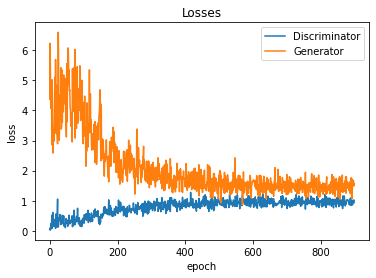

In [43]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

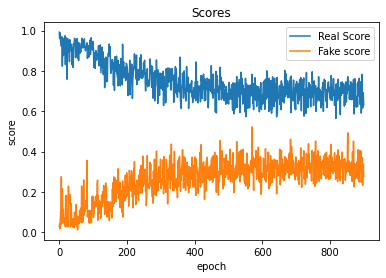

In [44]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

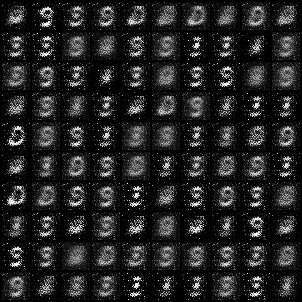

In [37]:
Image('./samples/fake_images-0010.png')

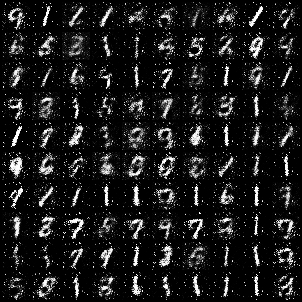

In [38]:
Image('./samples/fake_images-0050.png')

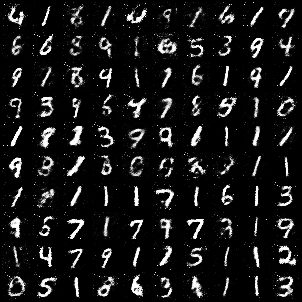

In [39]:
Image('./samples/fake_images-0100.png')

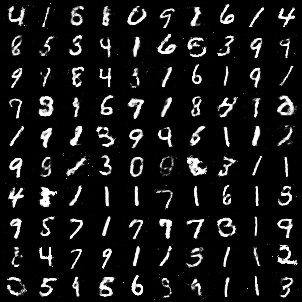

In [40]:
Image('./samples/fake_images-0300.png')

In [42]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()


In [45]:
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi